# Extra installments 

In [1]:
!pip install ecglib

In [2]:
!pip install -U scikit-learn

     ---------------------------------------- 8.4/8.4 MB 28.2 MB/s eta 0:00:00
     ------------------------------------- 298.0/298.0 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [3]:
!pip install seaborn

## Libraries 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as st
from scipy.stats import entropy
from scipy import stats
from numpy import mean, absolute
from sklearn.manifold import TSNE
import seaborn as sns

In [19]:
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

## Importing data sets

In [7]:
from ecglib.datasets import PTBXLDataset
from ecglib.datasets import load_ptb_xl

ptb_xl_info = load_ptb_xl(download=True)

Loading PTB-XL file...


100%|██████████| 1.84G/1.84G [19:56<00:00, 1.54MiB/s] 


Loading completed!
Unzipping PTB-XL file...


100%|██████████| 87211/87211 [04:42<00:00, 308.34it/s]


Unzipping completed!
Deleting ./ptb_xl.zip file...
Deleting completed!


In [8]:
# read in csv file
df_AFIB = pd.read_csv(r"C:\Users\Jessica Tran\Downloads\archive (5)\coorteeqsrafva (version 1).csv", sep=';', header=0, index_col=0)

# print df
print(df_AFIB.shape)
df_AFIB.head()

(6428, 30)


,diagnosi,ecg_id,ritmi,patient_id,age,sex,height,weight,nurse,site,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,STACH,10900,VA,15654.0,54.0,0,NaN,NaN,0.0,0.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/10000/10900_lr,records500/10000/10900_hr
1,AFLT,10900,AF,15654.0,54.0,0,NaN,NaN,0.0,0.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/10000/10900_lr,records500/10000/10900_hr
2,SR,8209,SR,12281.0,55.0,0,NaN,NaN,1.0,2.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/08000/08209_lr,records500/08000/08209_hr
3,STACH,17620,VA,2007.0,29.0,1,164.0,56.0,7.0,1.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,1,records100/17000/17620_lr,records500/17000/17620_hr
4,SBRAD,12967,VA,8685.0,57.0,0,NaN,NaN,0.0,0.0,...,False,NaN,", I-AVR,",NaN,NaN,NaN,NaN,1,records100/12000/12967_lr,records500/12000/12967_hr


In [9]:
# check rows for each category in ritmi column
print('Normal (SR) has a total of {} rows'.format(df_AFIB.loc[df_AFIB['ritmi'] == 'SR'].shape[0]))
print('Atrial Fibrillation (AF) has a total of {} rows'.format(df_AFIB.loc[df_AFIB['ritmi'] == 'AF'].shape[0]))
print('Other arrhythmia (VA) has a total of {} rows'.format(df_AFIB.loc[df_AFIB['ritmi'] == 'VA'].shape[0]))

Normal (SR) has a total of 2000 rows
Atrial Fibrillation (AF) has a total of 1587 rows
Other arrhythmia (VA) has a total of 2841 rows


In [10]:
# read in npy file 
ecgeq_arr = np.load(r"C:\Users\Jessica Tran\Downloads\archive (5)\ecgeq-500hzsrfava.npy")
print(ecgeq_arr.shape)
#ecgeq_arr

(6428, 5000, 12)


# Preprocessing

In [110]:
# Extracting r_peaks, labels and sex from the data set
r_peaks = []
labels = []
sex = []

for i in range(df_AFIB.shape[0]): #looking up ecg_id for NORM, AFIB and other arrhythmias
    lab = df_AFIB.loc[i,'ritmi']
    if lab == 'SR':
        labels.append(0.0)
    elif lab == 'AF':
        labels.append(1.0)
    else:
        labels.append(2.0)
    
    
    #iterate/extract every ecg_id in kaggle dataset
    ecg_id = df_AFIB.loc[i,'ecg_id']
    
    #determine the index for which the ecg_id are located in ptb_xl_info
    index = ptb_xl_info.index[ptb_xl_info['ecg_id'] == int(ecg_id)][0]

    r = ptb_xl_info.loc[int(index),'r_peaks'] #locating the r-peaks for the corresponding ecg_id
    r_peaks.append(r)
    
    y = ptb_xl_info.loc[int(index),'sex'] #locating the r-age for the corresponding ecg_id
    sex.append(y)

In [111]:
#Dataframe with 3 extracted features 
new_list = []

for i in range(len(r_peaks)):
    new = pd.Series([int(df_AFIB.loc[i,'ecg_id']),labels[i],r_peaks[i]], 
                    index = ['ecg_id','label','r_peaks'])
    new_list.append(new)

df_rpeaks = pd.DataFrame(new_list)
df_rpeaks

,ecg_id,label,r_peaks
0,10900,2.0,[ 22 64 106 148 190 232 274 315 358 402 445 4...
1,10900,1.0,[ 22 64 106 148 190 232 274 315 358 402 445 4...
2,8209,0.0,[ 33 102 171 241 310 379 448 518 587 657 726 7...
3,17620,2.0,[ 38 85 132 180 227 274 322 369 416 464 510 5...
4,12967,2.0,[ 74 200 324 454 579 713 832 969]
...,...,...,...
6423,4131,2.0,[ 32 145 244 353 447 517 594 671 759 862 963]
6424,18644,2.0,[ 13 73 132 192 251 309 368 418 487 536 592 6...
6425,3693,0.0,[ 46 121 196 272 349 426 502 577 652 727 803 8...
6426,1039,1.0,[133 252 313 406 501 617 748 806 925]


# Feature extraction

In [13]:
#Converting R-peaks to int and calculating RRI
rri_all = []

#converting list to int and calculate rri for all signals in dataset(ptb_xl_info)
for i in range(df_AFIB.shape[0]): 
    r = r_peaks[i].split() #convert string to list (still str)

    #deleting '[' and ']'
    rpeaks_list_str = []
    for i in range(len(r)):
        if i==0 or r[i]=='':
            continue
        elif i==len(r)-1:
            temp = r[i]
            temp1 = temp[:-1]
            rpeaks_list_str.append(temp1)
        else:
            rpeaks_list_str.append(r[i])

    #convert str to int
    rpeaks_list =[]
    for j in range(len(rpeaks_list_str)):
        rpeaks_list.append(int(rpeaks_list_str[j]))
    
    #calculate rri
    rri = np.diff((rpeaks_list))
    rri_all.append(rri)

In [15]:
# the 7 features
mean_rri = []
sd_rri = []
rmssd_list = []
nrmssd_list = []
entropy_list = []
mean_abs_dev = []
median_abs_dev = []

for i in range(len(rri_all)):
    #mean of RRI of each ECG signal
    mean = np.mean(rri_all[i])
    mean_rri.append(mean)
    
    #st.dev of RRI of each ECG signal
    sd = st.stdev(rri_all[i],mean_rri[i])
    sd_rri.append(sd)
    
    #root mean square of successive differences (RMSSD)
    rmssd = np.sqrt(np.mean(np.square(np.diff(rri_all[i]))))
    rmssd_list.append(rmssd)
    
    #normalized root mean square of successive differences (nRMSSD)
    nrmssd = rmssd_list[i]/mean_rri[i]
    nrmssd_list.append(nrmssd)
    
    #Shannon entropy
    ent = entropy(rri_all[i])
    entropy_list.append(ent)
    
    from numpy import mean, absolute
    #mean absolute deviation 
    mean_abs = mean(absolute(rri_all[i] - mean(rri_all[i])))
    mean_abs_dev.append(mean_abs)
    
    #median absolute deviation
    median_abs = stats.median_abs_deviation(rri_all[i])
    median_abs_dev.append(median_abs)

In [16]:
# building the dataframe for the feautures 
all_features = []

for i in range(len(rri_all)):
    new_features = pd.Series([df_rpeaks.loc[i,'ecg_id'],np.around(mean_rri[i],3), np.around(sd_rri[i],3), np.around(rmssd_list[i],3), np.around(nrmssd_list[i],3), 
                              np.around(entropy_list[i],3),np.around(mean_abs_dev[i],3), np.around(median_abs_dev[i],3), labels[i]],
                             index = ['ecg_id','Mean', 'Standard Deviation', 'RMSSD', 'Normalized RMSSD', 'Shannon Entropy',
                                      'Mean Absolute Deviation', 'Median Absolute Deviation', 'Label'])
    
    all_features.append(new_features)

In [17]:
df_features = pd.DataFrame((all_features))

df_features

,ecg_id,Mean,Standard Deviation,RMSSD,Normalized RMSSD,Shannon Entropy,Mean Absolute Deviation,Median Absolute Deviation,Label
0,10900.0,42.500,0.740,0.873,0.021,3.091,0.636,0.5,2.0
1,10900.0,42.500,0.740,0.873,0.021,3.091,0.636,0.5,1.0
2,8209.0,69.385,0.506,0.866,0.012,2.565,0.473,0.0,0.0
3,17620.0,46.950,0.605,0.918,0.020,2.996,0.380,0.0,2.0
4,12967.0,127.857,6.203,10.763,0.084,1.945,4.980,4.0,2.0
...,...,...,...,...,...,...,...,...,...
6423,4131.0,93.100,14.617,12.893,0.138,2.291,12.080,10.5,2.0
6424,18644.0,59.312,5.570,9.230,0.156,2.768,3.266,1.0,2.0
6425,3693.0,75.833,0.835,0.739,0.010,2.485,0.694,1.0,0.0
6426,1039.0,96.143,28.381,42.316,0.440,1.907,22.163,24.0,1.0


# Splitting in train and test set

In [21]:
X = df_features.drop(['ecg_id','Label'],axis=1)
y = df_features['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y)

cv = LeaveOneGroupOut()

In [32]:
# groups 
groups = np.random.randint(0,5,size=len(X))

valid_indices = np.intersect1d(np.intersect1d(np.arange(len(X)), np.arange(len(y))), np.arange(len(groups)))
    
groups_all = groups[valid_indices]
group_train, group_test, group_train, group_test = train_test_split(groups_all, groups_all, random_state = 42)

# KNN

In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Building the model
param_grid = {"n_neighbors": np.arange(1,11,2),"weights": ["uniform", "distance"]}
    
KNN = KNeighborsClassifier()
grid_search_KNN = GridSearchCV(KNN, param_grid, cv = cv, scoring = "accuracy")
grid_search_KNN.fit(X_train, y_train, groups = group_train)
    
y_pred_KNN = grid_search_KNN.predict(X_test)
y_true_KNN = y_test

best_score_KNN = grid_search_KNN.best_score_ 
best_params_KNN = grid_search_KNN.best_params_
        
print(f"Best Score: {best_score_KNN}")
print(f"Best Params: {best_params_KNN}")

Best Score: 0.798261243825703
Best Params: {'n_neighbors': 9, 'weights': 'distance'}


## Plots

### Classification report

In [34]:
# Classification report
target_names = ['NORM', 'AFIB', 'Other']

class_report_KNN = classification_report(y_true_KNN, y_pred_KNN, target_names=target_names)
print(class_report_KNN)

              precision    recall  f1-score   support

        NORM       0.81      0.86      0.83       477
        AFIB       0.79      0.86      0.82       402
       Other       0.84      0.75      0.79       728

    accuracy                           0.81      1607
   macro avg       0.81      0.83      0.82      1607
weighted avg       0.82      0.81      0.81      1607



### Confusion matrices

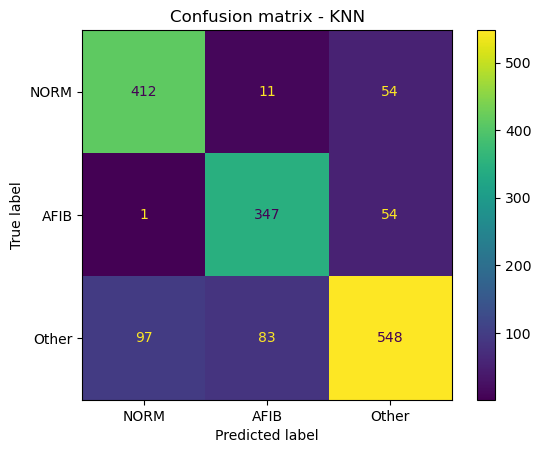

In [35]:
# Create the confusion matrix
cm_KNN = confusion_matrix(y_true_KNN, y_pred_KNN)

ConfusionMatrixDisplay(confusion_matrix = cm_KNN, display_labels=target_names).plot();
plt.title("Confusion matrix - KNN")
plt.savefig('Confusion_matrix_KNN')

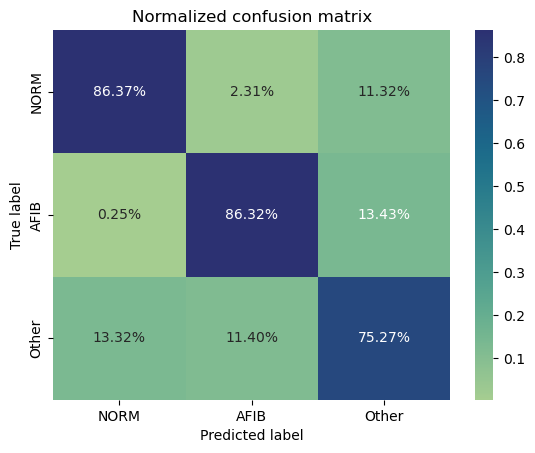

<Figure size 640x480 with 0 Axes>

In [70]:
# normalized confusion matrix
cm_normalized_KNN = cm_KNN.astype('float') / cm_KNN.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_KNN, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names,  linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()
plt.savefig('Normalized Confusion matrix KNN')

### ROC-curve + ROC-AUC

In [46]:
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

KNN = KNeighborsClassifier(n_neighbors = best_params_KNN['n_neighbors'], weights = best_params_KNN['weights'])

#taget det sidste fold - overvej om det skal tages for det bedste fold
clf = OneVsRestClassifier(KNN)
clf.fit(X_train, y_train)

#Predict class probabilities of the input
pred_prob_KNN = clf.predict_proba(X_test)

In [47]:
from sklearn.metrics import auc
# roc curve for classes
fpr_KNN = {}
tpr_KNN = {}
thresh_KNN = {}
n_class = 3
AUC_KNN = {}

for i in range(n_class):    
    fpr_KNN[i], tpr_KNN[i], thresh_KNN[i] = metrics.roc_curve(y_test, pred_prob_KNN[:,i], pos_label=i)
    AUC_KNN[i] = auc(fpr_KNN[i], tpr_KNN[i])

# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_KNN[i], tpr_KNN[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_KNN["macro"] = fpr_grid
tpr_KNN["macro"] = mean_tpr
AUC_KNN["macro"] = auc(fpr_KNN["macro"], tpr_KNN["macro"])

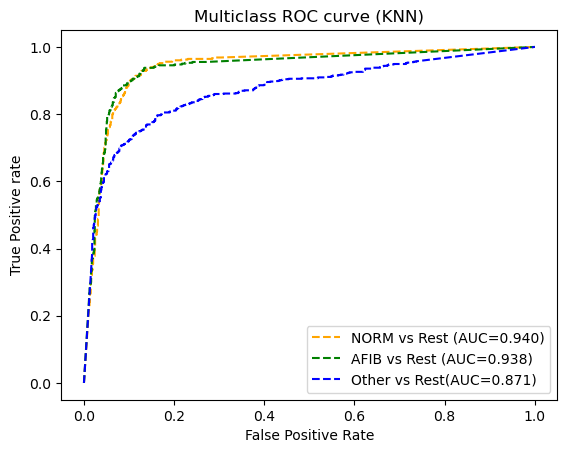

In [48]:
# plotting    
plt.plot(fpr_KNN[0], tpr_KNN[0], linestyle='--', color='orange', label = f'NORM vs Rest (AUC={AUC_KNN[0]:.3f})')
plt.plot(fpr_KNN[1], tpr_KNN[1], linestyle='--', color='green', label = f'AFIB vs Rest (AUC={AUC_KNN[1]:.3f})')
plt.plot(fpr_KNN[2], tpr_KNN[2], linestyle='--', color='blue', label = f'Other vs Rest(AUC={AUC_KNN[2]:.3f})')
plt.title('Multiclass ROC curve (KNN)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve (KNN)')

# Decision Tree

In [49]:
# Implementing classifier
param_grid = {"max_depth": np.arange(1,20)}

DT = DecisionTreeClassifier()
grid_search_DT = GridSearchCV(DT, param_grid, cv = cv, scoring = "accuracy")
grid_search_DT.fit(X_train, y_train, groups = group_train)
    
y_pred_DT = grid_search_DT.predict(X_test)
y_true_DT = y_test

best_score_DT = grid_search_DT.best_score_
best_params_DT = grid_search_DT.best_params_
        
print(f"Best Score: {best_score_DT}")
print(f'Best Params: {best_params_DT}')

Best Score: 0.7907982234312894
Best Params: {'max_depth': 6}


## Plots

### Classification report

In [ ]:
# Classification report
target_names = ['NORM', 'AFIB', 'Other']

class_report_DT = classification_report(y_true_DT, y_pred_DT, target_names=target_names)
print(class_report_DT)

### Confusion matrices

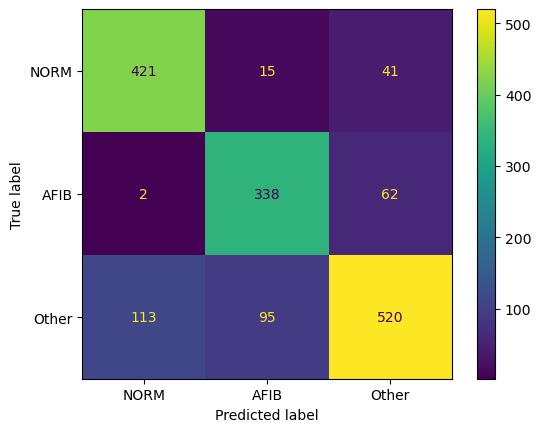

In [50]:
# Create the confusion matrix
cm_DT = confusion_matrix(y_true_DT, y_pred_DT)

ConfusionMatrixDisplay(confusion_matrix=cm_DT, display_labels=target_names).plot();

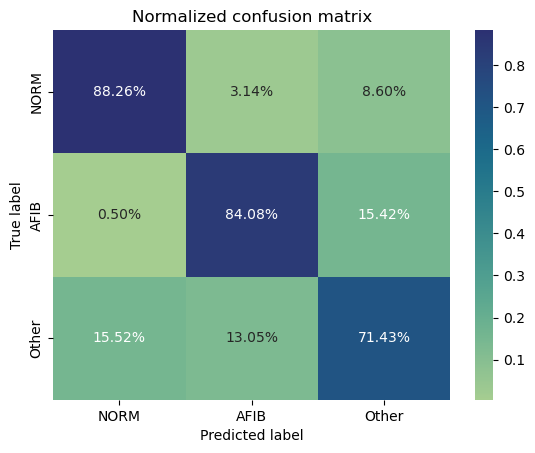

In [69]:
# normalized confusion matrix %
cm_normalized_DT = cm_DT.astype('float') / cm_DT.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_DT, annot=True,fmt='.2%', xticklabels=target_names,yticklabels=target_names,  linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()
# linewidths = 0.01

### Plotting the Tree

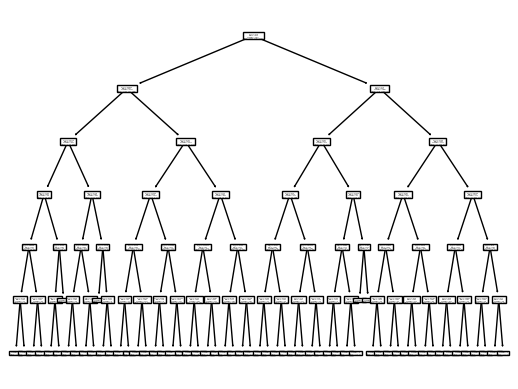

In [52]:
from sklearn.tree import plot_tree, DecisionTreeClassifier 

# Plot tree - last fold
tree = DecisionTreeClassifier(max_depth = best_params_DT['max_depth']).fit(X_train, y_train)
plot_tree(tree)

plt.show()

### Feature importance

Text(0.5, 0, 'Feature importance')

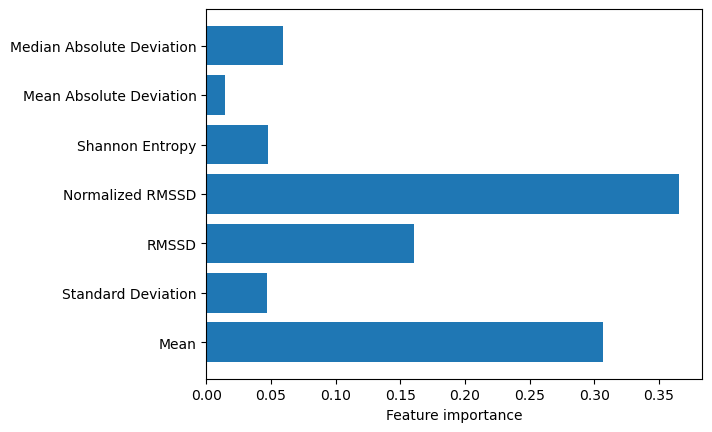

In [53]:
# Feature importance
labels = df_features.drop(['ecg_id','Label'], axis=1).columns

#Make a horizontal bar plot
plt.barh(range(7), tree.feature_importances_)
plt.yticks(range(7), labels)
plt.xlabel('Feature importance')

### ROC-curve + ROC-AUC

In [54]:
# ROC
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

DT = DecisionTreeClassifier(max_depth = best_params_DT['max_depth'])

#taget det sidste fold - overvej om det skal tages for det bedste fold
clf = OneVsRestClassifier(DT)
clf.fit(X_train, y_train)
pred_prob_DT = []

#Predict class probabilities of the input
pred_prob_DT = clf.predict_proba(X_test)

In [55]:
from sklearn.metrics import auc

# roc curve for classes
fpr_DT = {}
tpr_DT = {}
thresh_DT = {}
n_class = 3
AUC_DT = {}

for i in range(n_class):    
    fpr_DT[i], tpr_DT[i], thresh_DT[i] = metrics.roc_curve(y_test, pred_prob_DT[:,i], pos_label=i)
    AUC_DT[i] = auc(fpr_DT[i], tpr_DT[i])
    
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_DT[i], tpr_DT[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_DT["macro"] = fpr_grid
tpr_DT["macro"] = mean_tpr
AUC_DT["macro"] = auc(fpr_DT["macro"], tpr_DT["macro"])

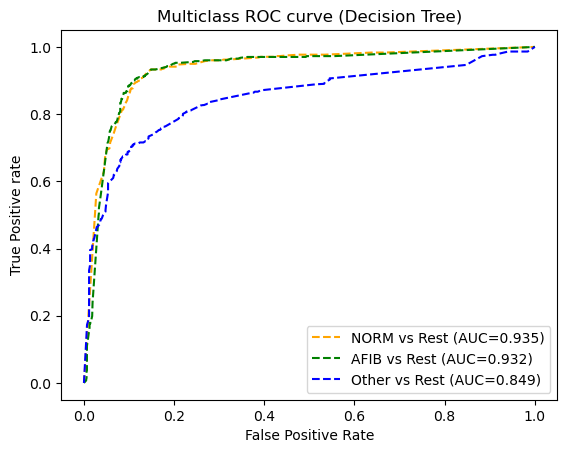

In [57]:
# plotting    
plt.plot(fpr_DT[0], tpr_DT[0], linestyle='--', color='orange', label = f'NORM vs Rest (AUC={AUC_DT[0]:.3f})')
plt.plot(fpr_DT[1], tpr_DT[1], linestyle='--', color='green', label = f'AFIB vs Rest (AUC={AUC_DT[1]:.3f})')
plt.plot(fpr_DT[2], tpr_DT[2], linestyle='--', color='blue', label = f'Other vs Rest (AUC={AUC_DT[2]:.3f})')
plt.title('Multiclass ROC curve (Decision Tree)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

# Random Forest

In [58]:
param_grid = {"n_estimators": np.arange(1,100,5),"max_depth": np.arange(1,10)}

RF = RandomForestClassifier()
grid_search_RF = GridSearchCV(RF, param_grid, cv = cv, scoring = "accuracy")
grid_search_RF.fit(X_train, y_train, groups = group_train)
    
y_pred_RF = grid_search_RF.predict(X_test)
y_true_RF = y_test
   
best_score_RF = grid_search_RF.best_score_
best_params_RF = grid_search_RF.best_params_
        
print(f'Best Score: {best_score_RF}')
print(f'Best Params: {best_params_RF}')

Best Score: 0.8080355280732497
Best Params: {'max_depth': 9, 'n_estimators': 46}


## Plots

### Classification report

In [60]:
target_names = ['NORM', 'AFIB', 'Other']
class_report_RF = classification_report(y_true_RF, y_pred_RF, target_names = target_names)
print(class_report_RF)

              precision    recall  f1-score   support

        NORM       0.80      0.88      0.84       477
        AFIB       0.78      0.85      0.81       402
       Other       0.84      0.75      0.79       728

    accuracy                           0.81      1607
   macro avg       0.81      0.82      0.81      1607
weighted avg       0.81      0.81      0.81      1607



### Confusion matrices

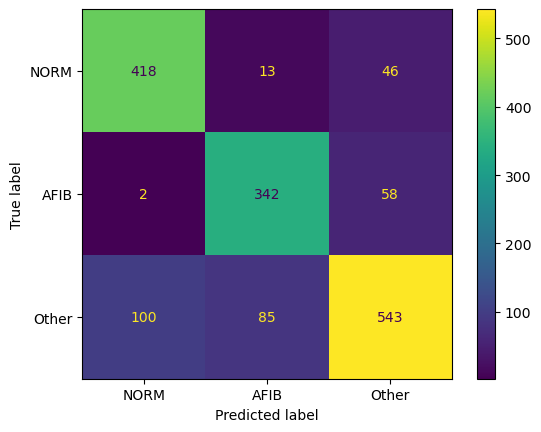

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create the confusion matrix - bedste fold
cm_RF = confusion_matrix(y_true_RF, y_pred_RF)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_RF, display_labels = target_names).plot();

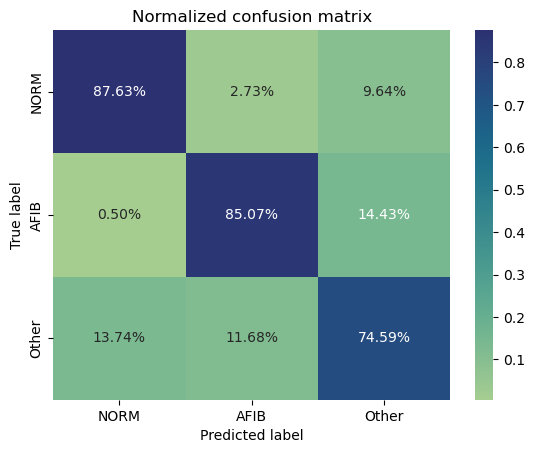

In [68]:
# normalized confusion matrix
cm_normalized_RF = cm_RF.astype('float') / cm_RF.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_RF, annot = True, fmt = '.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

### Features importance

Text(0.5, 0, 'Feature importance')

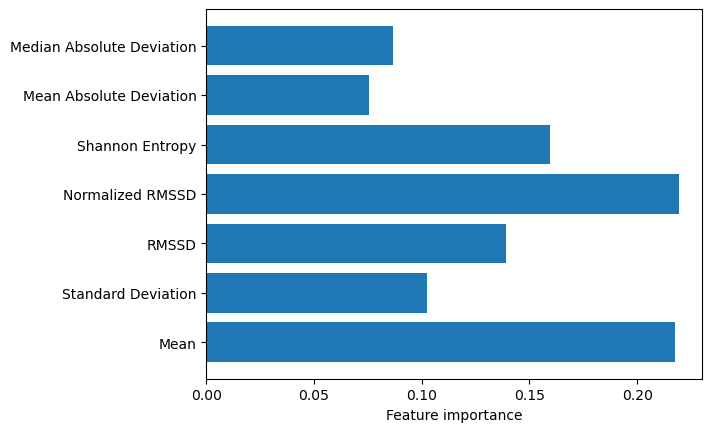

In [71]:
clf = RandomForestClassifier(n_estimators=best_params_RF['n_estimators'], 
                             max_depth=best_params_RF['max_depth']).fit(X_train, y_train)


labels = df_features.drop(['ecg_id','Label'],axis=1).columns

plt.barh(range(7), clf.feature_importances_)
plt.yticks(range(7), labels)
plt.xlabel('Feature importance')

### ROC-curve + ROC-AUC

In [72]:
# ROC
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

RF = RandomForestClassifier(n_estimators = best_params_RF['n_estimators'], max_depth = best_params_RF['max_depth'])

#taget det sidste fold - overvej om det skal tages for det bedste fold
clf = OneVsRestClassifier(RF)
clf.fit(X_train, y_train)

pred_prob_RF = clf.predict_proba(X_test)

In [73]:
from sklearn.metrics import auc

# roc curve for classes
fpr_RF = {}
tpr_RF = {}
thresh_RF = {}
n_class = 3
AUC_RF = {}

for i in range(n_class):    
    fpr_RF[i], tpr_RF[i], thresh_RF[i] = metrics.roc_curve(y_test, pred_prob_RF[:,i], pos_label=i)
    AUC_RF[i] = auc(fpr_RF[i], tpr_RF[i])

# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_RF[i], tpr_RF[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_RF["macro"] = fpr_grid
tpr_RF["macro"] = mean_tpr
AUC_RF["macro"] = auc(fpr_RF["macro"], tpr_RF["macro"])

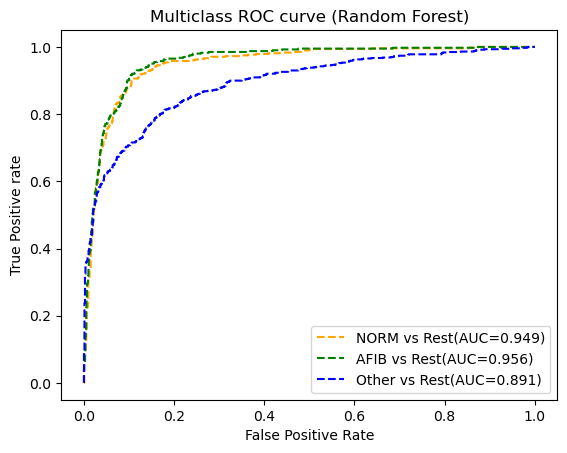

In [74]:
# plotting    
plt.plot(fpr_RF[0], tpr_RF[0], linestyle='--', color='orange', label = f'NORM vs Rest(AUC={AUC_RF[0]:.3f})')
plt.plot(fpr_RF[1], tpr_RF[1], linestyle='--', color='green', label = f'AFIB vs Rest(AUC={AUC_RF[1]:.3f})')
plt.plot(fpr_RF[2], tpr_RF[2], linestyle='--', color='blue', label = f'Other vs Rest(AUC={AUC_RF[2]:.3f})')
plt.title('Multiclass ROC curve (Random Forest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc = 'best')
#plt.savefig('Multiclass ROC',dpi=300);   

# Adaptive Boosting (AdaBoost)

In [75]:
#Adaboost (ensemble)
from sklearn.ensemble import AdaBoostClassifier

param_grid = {"n_estimators": np.arange(1,100)}

ada = AdaBoostClassifier()
grid_search_ada = GridSearchCV(ada, param_grid, cv = cv, scoring = "accuracy")
grid_search_ada.fit(X_train, y_train, groups = group_train)

y_pred_ada = grid_search_ada.predict(X_test)
y_true_ada = y_test
    
best_score_ada = grid_search_ada.best_score_
best_params_ada = grid_search_ada.best_params_
        
print(f'Best score: {best_score_ada}')
print(f'Best Params: {best_params_ada}')

Best score: 0.7791373574103971
Best Params: {'n_estimators': 45}


## Plots

### Classification report

In [76]:
target_names = ['NORM', 'AFIB', 'other']

class_report_ada = classification_report(y_true_ada, y_pred_ada, target_names=target_names)
print(class_report_ada)

              precision    recall  f1-score   support

        NORM       0.78      0.79      0.79       477
        AFIB       0.77      0.86      0.82       402
       other       0.80      0.73      0.76       728

    accuracy                           0.78      1607
   macro avg       0.78      0.80      0.79      1607
weighted avg       0.79      0.78      0.78      1607



### Confusion matrices

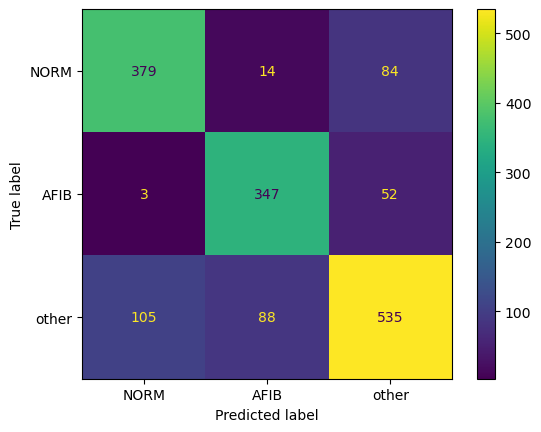

In [77]:
# Create the confusion matrix
cm_ada = confusion_matrix(y_true_ada, y_pred_ada)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_ada, display_labels = target_names).plot();

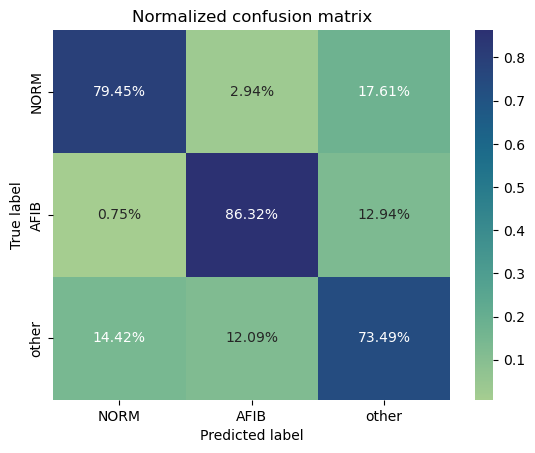

In [79]:
# normalized confusion matrix %
cm_normalized_ada = cm_ada.astype('float') / cm_ada.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_ada, annot = True, fmt = '.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

### ROC-curve + ROC-AUC

In [80]:
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

ada = AdaBoostClassifier(n_estimators = best_params_ada['n_estimators'])

#taget det sidste fold - overvej om det skal tages for det bedste fold
clf = OneVsRestClassifier(ada)
clf.fit(X_train, y_train)

#Predict class probabilities of the input
pred_prob_ada = clf.predict_proba(X_test)

In [81]:
from sklearn.metrics import auc

# roc curve for classes
fpr_ada = {}
tpr_ada = {}
thresh_ada = {}
n_class = 3
AUC_ada = {}

for i in range(n_class):    
    fpr_ada[i], tpr_ada[i], thresh_ada[i] = metrics.roc_curve(y_test, pred_prob_ada[:,i], pos_label=i)
    AUC_ada[i] = auc(fpr_ada[i], tpr_ada[i])
    
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_ada[i], tpr_ada[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_ada["macro"] = fpr_grid
tpr_ada["macro"] = mean_tpr
AUC_ada["macro"] = auc(fpr_ada["macro"], tpr_ada["macro"])

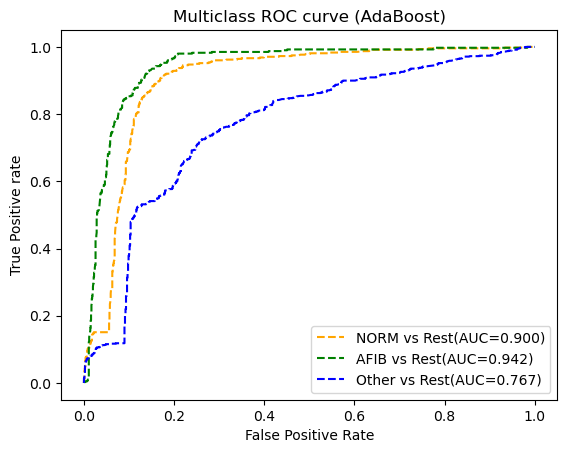

In [82]:
# plotting    
plt.plot(fpr_ada[0], tpr_ada[0], linestyle='--', color='orange', label = f'NORM vs Rest(AUC={AUC_ada[0]:.3f})')
plt.plot(fpr_ada[1], tpr_ada[1], linestyle='--', color='green', label = f'AFIB vs Rest(AUC={AUC_ada[1]:.3f})')
plt.plot(fpr_ada[2], tpr_ada[2], linestyle='--', color='blue', label = f'Other vs Rest(AUC={AUC_ada[2]:.3f})')
plt.title('Multiclass ROC curve (AdaBoost)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

# Ensemble Voting Classifier (EVC)

## Hard voting

In [83]:
#hard voting
param_grid = {}
    
EVCh = VotingClassifier(estimators = [('KNN', KNeighborsClassifier(n_neighbors = best_params_KNN['n_neighbors'], weights = best_params_KNN['weights'])), 
                                       ('DT', DecisionTreeClassifier(max_depth = best_params_DT['max_depth'])), 
                                       ('RF', RandomForestClassifier(n_estimators = best_params_RF['n_estimators'], max_depth = best_params_RF['max_depth'])),
                                       ('Ada',AdaBoostClassifier(n_estimators = best_params_ada['n_estimators']))], voting='hard')
grid_search_EVCh = GridSearchCV(EVCh, param_grid, cv = cv, scoring = "accuracy")
grid_search_EVCh.fit(X_train, y_train, groups = group_train)
    
y_pred_EVCh = grid_search_EVCh.predict(X_test)
y_true_EVCh = y_test
   
best_score_EVCh = grid_search_EVCh.best_score_
        
print(f'Best Score: {best_score_EVCh}')

Best Score: 0.8041420612225842


## Plots

### Classification report

In [84]:
target_names = ['NORM', 'AFIB', 'Other']

class_report_EVCh = classification_report(y_true_EVCh, y_pred_EVCh, target_names=target_names)
print(class_report_EVCh)

              precision    recall  f1-score   support

        NORM       0.79      0.88      0.83       477
        AFIB       0.77      0.87      0.81       402
       Other       0.85      0.72      0.78       728

    accuracy                           0.81      1607
   macro avg       0.80      0.82      0.81      1607
weighted avg       0.81      0.81      0.81      1607



### Confusion matrices

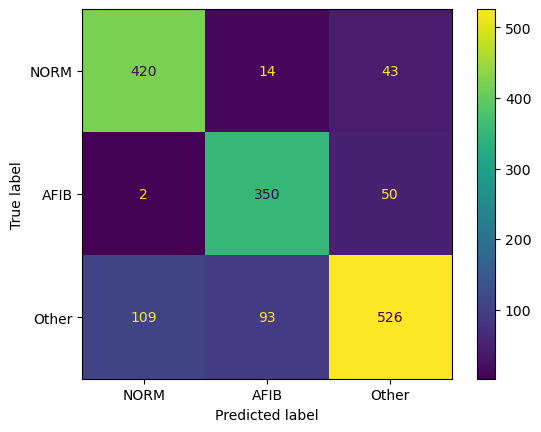

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Create the confusion matrix
cm_EVCh = confusion_matrix(y_true_EVCh, y_pred_EVCh)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_EVCh, display_labels = target_names).plot();

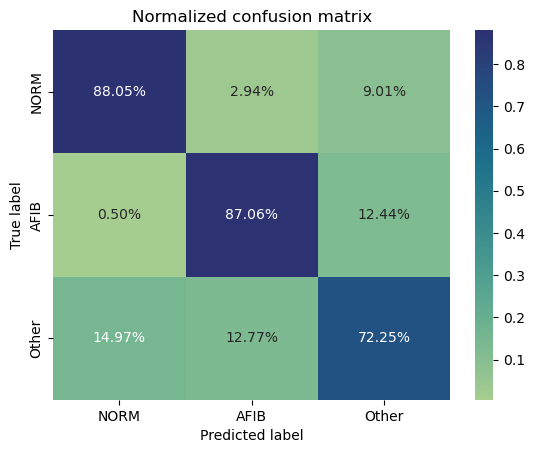

In [86]:
# normalized confusion matrix %
cm_normalized_EVCh = cm_EVCh.astype('float') / cm_EVCh.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_EVCh, annot = True, fmt = '.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()
# linewidths = 0.01

### ROC-curve + ROC-AUC

In [91]:
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(EVCh)
clf.fit(X_train, y_train)

#Predict class probabilities of the input
pred_prob_EVCh = clf.predict_proba(X_test)

In [92]:
from sklearn.metrics import auc

# roc curve for classes
fpr_EVCh = {}
tpr_EVCh = {}
thresh_EVCh = {}
n_class = 3
AUC_EVCh = {}

for i in range(n_class):    
    fpr_EVCh[i], tpr_EVCh[i], thresh_EVCh[i] = metrics.roc_curve(y_test, pred_prob_EVCh[:,i], pos_label=i)
    AUC_EVCh[i] = auc(fpr_EVCh[i], tpr_EVCh[i])
    
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_EVCh[i], tpr_EVCh[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_EVCh["macro"] = fpr_grid
tpr_EVCh["macro"] = mean_tpr
AUC_EVCh["macro"] = auc(fpr_EVCh["macro"], tpr_EVCh["macro"])

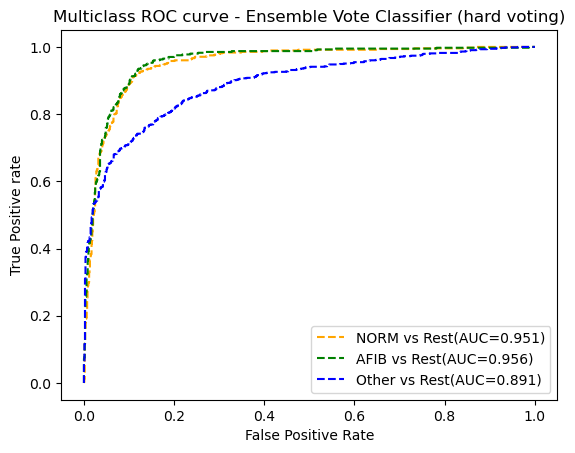

In [93]:
# plotting    
plt.plot(fpr_EVCh[0], tpr_EVCh[0], linestyle='--', color='orange', label = f'NORM vs Rest(AUC={AUC_EVCh[0]:.3f})')
plt.plot(fpr_EVCh[1], tpr_EVCh[1], linestyle='--', color='green', label = f'AFIB vs Rest(AUC={AUC_EVCh[1]:.3f})')
plt.plot(fpr_EVCh[2], tpr_EVCh[2], linestyle='--', color='blue', label = f'Other vs Rest(AUC={AUC_EVCh[2]:.3f})')
plt.title('Multiclass ROC curve - Ensemble Vote Classifier (hard voting)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

## Soft voting

In [89]:
param_grid = {}
    
EVCs = VotingClassifier(estimators = [('KNN', KNeighborsClassifier(n_neighbors = best_params_KNN['n_neighbors'], weights = best_params_KNN['weights'])), 
                                       ('DT', DecisionTreeClassifier(max_depth = best_params_DT['max_depth'])), 
                                       ('RF', RandomForestClassifier(n_estimators = best_params_RF['n_estimators'], max_depth = best_params_RF['max_depth'])),
                                       ('Ada',AdaBoostClassifier(n_estimators = best_params_ada['n_estimators']))], voting='soft')
grid_search_EVCs = GridSearchCV(EVCs, param_grid,cv = cv, scoring = "accuracy")
grid_search_EVCs.fit(X_train, y_train, groups = group_train)
    
y_pred_EVCs = grid_search_EVCs.predict(X_test)
y_true_EVCs = y_test
   
best_score_EVCs = grid_search_EVCs.best_score_
        
print(f'Best Score: {best_score_EVCs}')

Best Score: 0.8083383735874208


## Plots

### Classification report

In [94]:
target_names = ['NORM', 'AFIB', 'Other']

class_report_EVCs = classification_report(y_true_EVCs, y_pred_EVCs, target_names = target_names, output_dict=False)
print(class_report_EVCs)

              precision    recall  f1-score   support

        NORM       0.80      0.88      0.84       477
        AFIB       0.78      0.85      0.81       402
       Other       0.84      0.74      0.79       728

    accuracy                           0.81      1607
   macro avg       0.81      0.82      0.81      1607
weighted avg       0.81      0.81      0.81      1607



### Confusion matrices

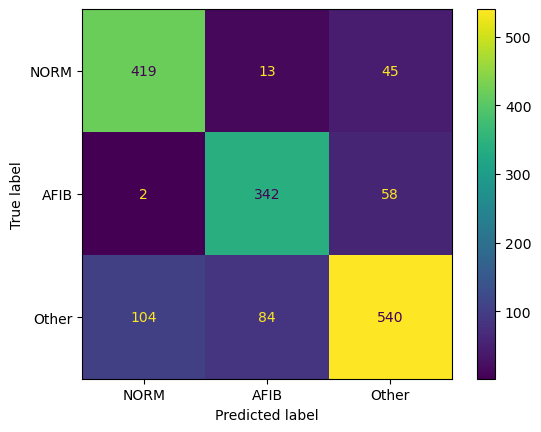

In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Create the confusion matrix
cm_EVCs = confusion_matrix(y_true_EVCs, y_pred_EVCs)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_EVCs, display_labels = target_names).plot();

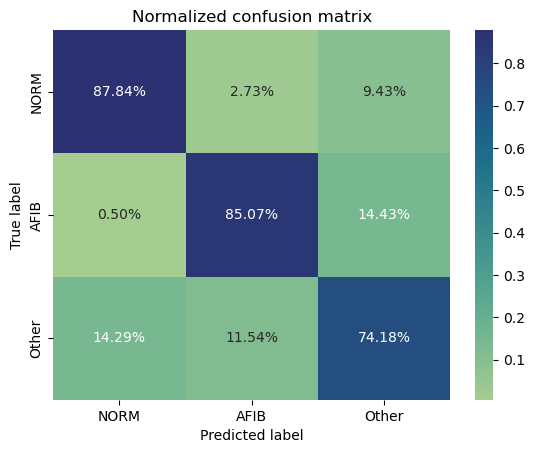

In [96]:
# normalized confusion matrix %
cm_normalized_EVCs = cm_EVCs.astype('float') / cm_EVCs.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_EVCs, annot = True, fmt = '.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

### ROC-curve + ROC-AUC

In [97]:
#ROC
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(EVCs)
clf.fit(X_train, y_train)

#Predict class probabilities of the input
pred_prob_EVCs = clf.predict_proba(X_test)

In [98]:
from sklearn.metrics import auc

# roc curve for classes
fpr_EVCs = {}
tpr_EVCs = {}
thresh_EVCs = {}
n_class = 3
AUC_EVCs= {}

for i in range(n_class):    
    fpr_EVCs[i], tpr_EVCs[i], thresh_EVCs[i] = metrics.roc_curve(y_test, pred_prob_EVCs[:,i], pos_label=i)
    AUC_EVCs[i] = auc(fpr_EVCs[i], tpr_EVCs[i])
    
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_EVCs[i], tpr_EVCs[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_EVCs["macro"] = fpr_grid
tpr_EVCs["macro"] = mean_tpr
AUC_EVCs["macro"] = auc(fpr_EVCs["macro"], tpr_EVCs["macro"])

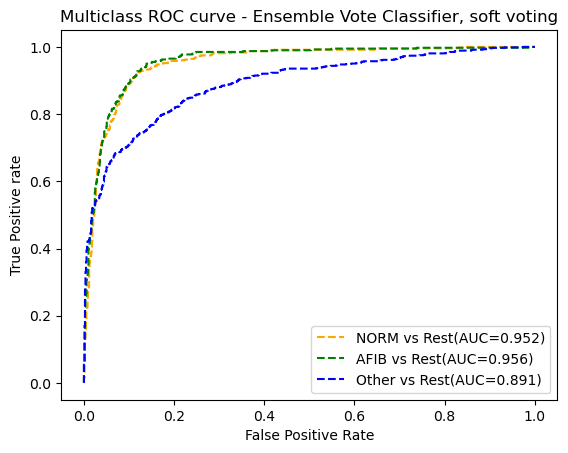

In [99]:
# plotting    
plt.plot(fpr_EVCs[0], tpr_EVCs[0], linestyle='--', color='orange', label = f'NORM vs Rest(AUC={AUC_EVCs[0]:.3f})')
plt.plot(fpr_EVCs[1], tpr_EVCs[1], linestyle='--', color='green', label = f'AFIB vs Rest(AUC={AUC_EVCs[1]:.3f})')
plt.plot(fpr_EVCs[2], tpr_EVCs[2], linestyle='--', color='blue', label = f'Other vs Rest(AUC={AUC_EVCs[2]:.3f})')
plt.title('Multiclass ROC curve - Ensemble Vote Classifier, soft voting')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

# Investigation of gender bias

## Plots of the data set according to gender

In [112]:
data = []

for i in range(len(labels)):
    new = pd.Series([df_rpeaks.loc[i,'ecg_id'],sex[i], labels[i]],
                        index = ['ecg_id', 'sex', 'Label'])
    
    data.append(new)
    
df_plot = pd.DataFrame((data))

<BarContainer object of 1 artists>

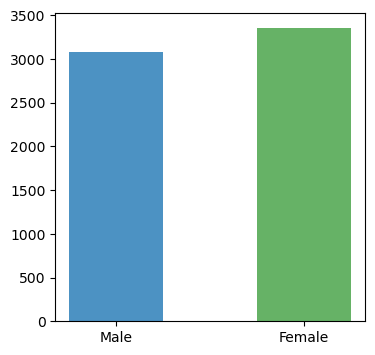

In [113]:
#plot male vs female
male = []
female = []

for i in range(df_plot.shape[0]):
    if df_plot.loc[i,'sex'] == 1:
        male.append(df_plot.loc[i,'sex'])
    else:
        female.append(df_plot.loc[i,'sex'])
        
plt.figure(figsize=(4,4))
plt.bar('Male',len(male),width=0.5,alpha=0.8)
plt.bar('Female',len(female),width=0.5,color='green',alpha=0.6)

In [107]:
male = {'NORM': 0, 'AFIB': 0, 'Other': 0}
female = {'NORM': 0, 'AFIB': 0, 'Other': 0}

for i in range(df_plot.shape[0]):
    sex = df_plot.loc[i,'sex']
    label = df_plot.loc[i,'Label']
    if sex == 0.0:
        if label == 0.0:
            female['NORM'] += 1
        if label == 1.0:
            female['AFIB'] += 1
        else:
            female['Other'] += 1
    else:
        if label == 0.0:
            male['NORM'] += 1
        if label == 1.0:
            male['AFIB'] += 1
        else:
            male['Other'] += 1
            
print(male)
print(female)

{'NORM': 999, 'AFIB': 688, 'Other': 2387}
{'NORM': 1001, 'AFIB': 899, 'Other': 2454}


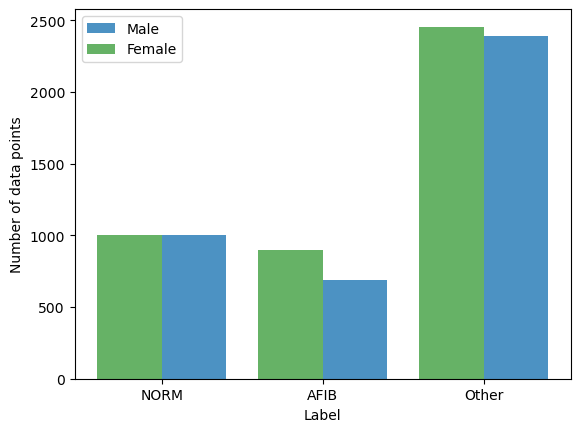

In [108]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['NORM','AFIB','Other']
Yfemale = [female['NORM'],female['AFIB'],female['Other']]
Zmale = [male['NORM'],male['AFIB'],male['Other']]
  
X_axis = np.arange(len(X))

plt.bar(X_axis + 0.2, Zmale, 0.4, label = 'Male', alpha = 0.8)
plt.bar(X_axis - 0.2, Yfemale, 0.4, label = 'Female', color = 'green', alpha = 0.6)
  
plt.xticks(X_axis, X)
plt.xlabel("Label")
plt.ylabel("Number of data points")
plt.legend()
plt.show()

## Splitting the dateframe according to gender

In [114]:
# dataframe with features and adding sex to it
df2 = df_features
df2['Sex'] = sex

# making dataframe only containing male - columns: features and label
df2_male = df2.drop(['ecg_id'], axis = 1)
df2_male = df2_male[df2_male["Sex"] == 1.0]

# making dataframe only containing female - columns: features and label
df2_female = df2.drop(['ecg_id'], axis = 1)
df2_female = df2_female[df2_female["Sex"] == 0.0]

## Train: 100% female , Test: 20% female + 100% male

### Splitting into train and test set

In [115]:
from sklearn.model_selection import train_test_split

#splitting female
X_female = df2_female.drop(['Label'], axis = 1)
y_female = df2_female['Label']

X_train1_female, X_test1_female, y_train1_female, y_test1_female = train_test_split(X_female, y_female, test_size = 0.2, shuffle = True)

# sorting male
X_male = df2_male.drop(['Label'], axis = 1)
y_male = df2_male['Label']

X_test1_male = X_male
y_test1_male = y_male

### KNN

In [117]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# train model
KNN = KNeighborsClassifier(n_neighbors = best_params_KNN['n_neighbors'], weights = best_params_KNN['weights'])
KNN.fit(X_train1_female, y_train1_female)

# testing model 20% female
y_pred_KNN1_female = KNN.predict(X_test1_female)
y_true_KNN1_female = y_test1_female

score1_female = KNN.score(X_test1_female, y_test1_female)
print(f"Score for female: {score1_female}")

# testing model 100% male
y_pred_KNN1_male = KNN.predict(X_test1_male)
y_true_KNN1_male = y_test1_male

score1_male = KNN.score(X_test1_male, y_test1_male)
print(f"Score for male: {score1_male}")

Score for female: 0.7928464977645305
Score for male: 0.7921951219512195


#### Plots

##### Classification report

In [118]:
target_names = ['NORM', 'AFIB', 'Other']

#female
class_report_KNN1_female = classification_report(y_true_KNN1_female, y_pred_KNN1_female, target_names = target_names)
print(class_report_KNN1_female)

#male
class_report_KNN1_male = classification_report(y_true_KNN1_male, y_pred_KNN1_male, target_names = target_names)
print(class_report_KNN1_male)

              precision    recall  f1-score   support

        NORM       0.80      0.84      0.82       190
        AFIB       0.78      0.84      0.81       196
       Other       0.80      0.73      0.77       285

    accuracy                           0.79       671
   macro avg       0.79      0.80      0.80       671
weighted avg       0.79      0.79      0.79       671

              precision    recall  f1-score   support

        NORM       0.81      0.85      0.83       999
        AFIB       0.70      0.89      0.79       688
       Other       0.84      0.70      0.77      1388

    accuracy                           0.79      3075
   macro avg       0.79      0.81      0.79      3075
weighted avg       0.80      0.79      0.79      3075



##### Confusion matrix

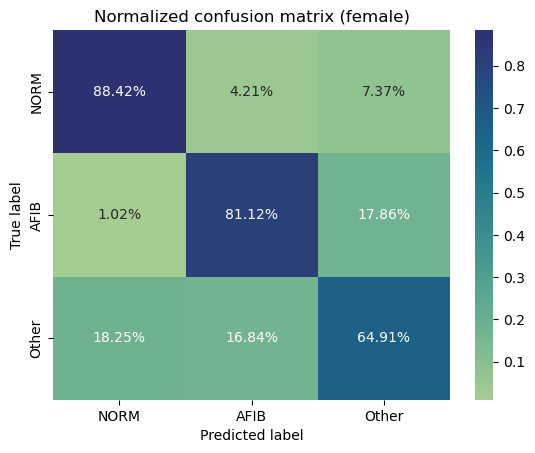

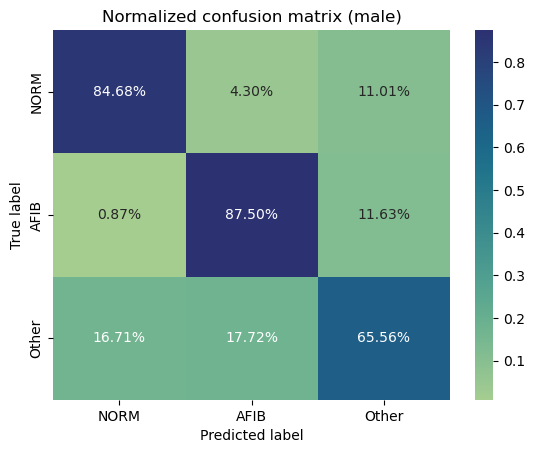

In [137]:
# normalized confusion matrix, female
cm_KNN1_female = confusion_matrix(y_true_DT1_female, y_pred_DT1_female)
cm_KNN1_male = confusion_matrix(y_true_DT1_male, y_pred_DT1_male)

cm_normalized_KNN1_female = cm_KNN1_female.astype('float') / cm_KNN1_female.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_KNN1_female, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (female)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

# normalized confusion matrix, male
cm_normalized_KNN1_male = cm_KNN1_male.astype('float') / cm_KNN1_male.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_KNN1_male, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (male)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

##### ROC-curve +ROC-AUC

In [122]:
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

#taget det sidste fold - overvej om det skal tages for det bedste fold
clf = OneVsRestClassifier(KNN)
clf.fit(X_train1_female, y_train1_female)

#Predict class probabilities of the input
pred_prob_KNN1_female = clf.predict_proba(X_test1_female)
pred_prob_KNN1_male = clf.predict_proba(X_test1_male)

In [123]:
from sklearn.metrics import auc

# roc curve for classes
fpr_KNN1_female = {}
tpr_KNN1_female = {}
thresh_KNN1_female = {}
AUC_KNN1_female = {}

fpr_KNN1_male = {}
tpr_KNN1_male = {}
thresh_KNN1_male = {}
AUC_KNN1_male = {}

n_class = 3

#female
for i in range(n_class):    
    fpr_KNN1_female[i], tpr_KNN1_female[i], thresh_KNN1_female[i] = metrics.roc_curve(y_test1_female, pred_prob_KNN1_female[:,i], pos_label=i)
    AUC_KNN1_female[i] = auc(fpr_KNN1_female[i], tpr_KNN1_female[i])

#male
for i in range(n_class):    
    fpr_KNN1_male[i], tpr_KNN1_male[i], thresh_KNN1_male[i] = metrics.roc_curve(y_test1_male, pred_prob_KNN1_male[:,i], pos_label=i)
    AUC_KNN1_male[i] = auc(fpr_KNN1_male[i], tpr_KNN1_male[i])

## female
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_KNN1_female[i], tpr_KNN1_female[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_KNN1_female["macro"] = fpr_grid
tpr_KNN1_female["macro"] = mean_tpr
AUC_KNN1_female["macro"] = auc(fpr_KNN1_female["macro"], tpr_KNN1_female["macro"])

## male
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_KNN1_male[i], tpr_KNN1_male[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_KNN1_male["macro"] = fpr_grid
tpr_KNN1_male["macro"] = mean_tpr
AUC_KNN1_male["macro"] = auc(fpr_KNN1_male["macro"], tpr_KNN1_male["macro"])

AUC (female: {0: 0.9379472589998905, 1: 0.9302738990332975, 2: 0.8583992364330515, 'macro': 0.9089320512876936}
AUC (male): {0: 0.9265276837531172, 1: 0.9404267665942458, 2: 0.8588229365430509, 'macro': 0.9085940476295586}


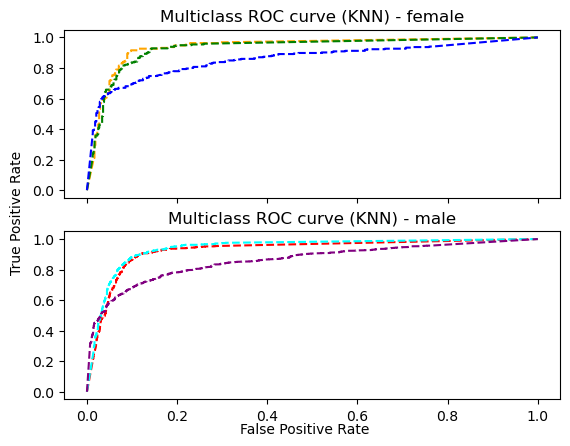

In [129]:
fig, (ax1, ax2) = plt.subplots(2,sharex=True)

# plotting, female
ax1.plot(fpr_KNN1_female[0], tpr_KNN1_female[0], linestyle='--', color='orange')
ax1.plot(fpr_KNN1_female[1], tpr_KNN1_female[1], linestyle='--', color='green')
ax1.plot(fpr_KNN1_female[2], tpr_KNN1_female[2], linestyle='--', color='blue')
ax1.set_title('Multiclass ROC curve (KNN) - female')

# plotting, male  
ax2.plot(fpr_KNN1_male[0], tpr_KNN1_male[0], linestyle='--', color='red')
ax2.plot(fpr_KNN1_male[1], tpr_KNN1_male[1], linestyle='--', color='cyan')
ax2.plot(fpr_KNN1_male[2], tpr_KNN1_male[2], linestyle='--', color='purple')

ax2.set_title('Multiclass ROC curve (KNN) - male')
fig.text(0.04, 0.5, 'True Positive Rate', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'False Positive Rate', ha='center')

print(f'AUC (female: {AUC_KNN1_female}')
print(f'AUC (male): {AUC_KNN1_male}')

### Decision Tree

In [130]:
# Implementing classifier
DT = DecisionTreeClassifier(max_depth = best_params_DT['max_depth'])
DT.fit(X_train1_female, y_train1_female)
    
# testing model 20% female
y_pred_DT1_female = DT.predict(X_test1_female)
y_true_DT1_female = y_test1_female

score1_female = DT.score(X_test1_female, y_test1_female)
print(f"Score for female: {score1_female}")

# testing model 100% male
y_pred_DT1_male = DT.predict(X_test1_male)
y_true_DT1_male = y_test1_male

score1_male = DT.score(X_test1_male, y_test1_male)
print(f"Score for male: {score1_male}")

Score for female: 0.7630402384500745
Score for male: 0.7668292682926829


#### Plots

##### Classification report

In [131]:
target_names = ['NORM', 'AFIB', 'Other']

#female
class_report_DT1_female = classification_report(y_true_DT1_female, y_pred_DT1_female, target_names=target_names)
print(class_report_DT1_female)

#male
class_report_DT1_male = classification_report(y_true_DT1_male, y_pred_DT1_male, target_names=target_names)
print(class_report_DT1_male)

              precision    recall  f1-score   support

        NORM       0.76      0.88      0.82       190
        AFIB       0.74      0.81      0.77       196
       Other       0.79      0.65      0.71       285

    accuracy                           0.76       671
   macro avg       0.76      0.78      0.77       671
weighted avg       0.77      0.76      0.76       671

              precision    recall  f1-score   support

        NORM       0.78      0.85      0.81       999
        AFIB       0.68      0.88      0.76       688
       Other       0.83      0.66      0.73      1388

    accuracy                           0.77      3075
   macro avg       0.76      0.79      0.77      3075
weighted avg       0.78      0.77      0.76      3075



##### Confusion matrix

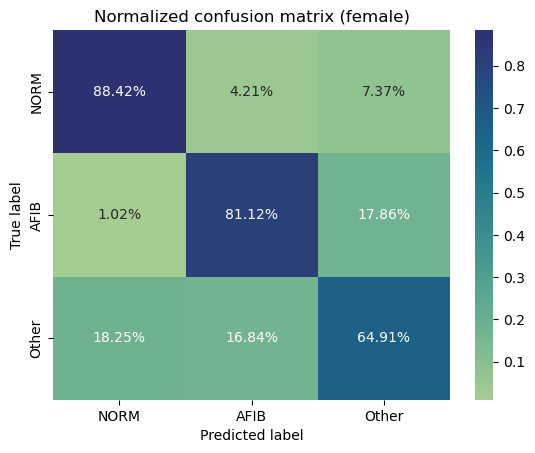

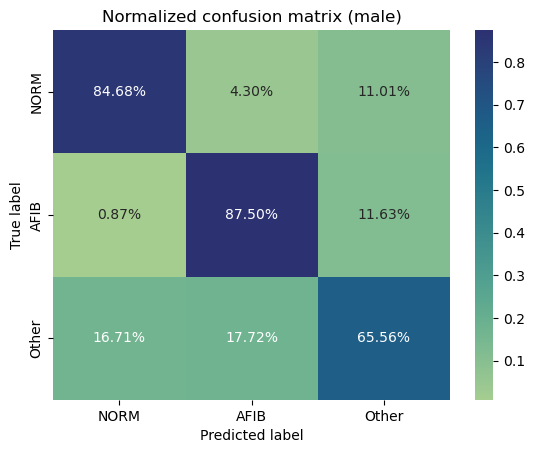

In [138]:
cm_DT1_female = confusion_matrix(y_true_DT1_female, y_pred_DT1_female)
cm_DT1_male = confusion_matrix(y_true_DT1_male, y_pred_DT1_male)

# normalized confusion matrix, female
cm_normalized_DT1_female = cm_DT1_female.astype('float') / cm_DT1_female.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_DT1_female, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (female)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

# normalized confusion matrix, male
cm_normalized_DT1_male = cm_DT1_male.astype('float') / cm_DT1_male.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_DT1_male, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (male)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

##### ROC-curve + ROC-AUC

In [139]:
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(DT)
clf.fit(X_train1_female, y_train1_female)

#Predict class probabilities of the input
pred_prob_DT1_female = clf.predict_proba(X_test1_female)
pred_prob_DT1_male = clf.predict_proba(X_test1_male)

In [140]:
from sklearn.metrics import auc

# roc curve for classes
fpr_DT1_female = {}
tpr_DT1_female = {}
thresh_DT1_female = {}
AUC_DT1_female = {}

fpr_DT1_male = {}
tpr_DT1_male = {}
thresh_DT1_male = {}
AUC_DT1_male = {}

n_class = 3

#female
for i in range(n_class):    
    fpr_DT1_female[i], tpr_DT1_female[i], thresh_DT1_female[i] = metrics.roc_curve(y_test1_female, pred_prob_DT1_female[:,i], pos_label=i)
    AUC_DT1_female[i] = auc(fpr_DT1_female[i], tpr_DT1_female[i])

#male
for i in range(n_class):    
    fpr_DT1_male[i], tpr_DT1_male[i], thresh_DT1_male[i] = metrics.roc_curve(y_test1_male, pred_prob_DT1_male[:,i], pos_label=i)
    AUC_DT1_male[i] = auc(fpr_DT1_male[i], tpr_DT1_male[i])

## female
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_DT1_female[i], tpr_DT1_female[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_DT1_female["macro"] = fpr_grid
tpr_DT1_female["macro"] = mean_tpr
AUC_DT1_female["macro"] = auc(fpr_DT1_female["macro"], tpr_DT1_female["macro"])

## male
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_DT1_male[i], tpr_DT1_male[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_DT1_male["macro"] = fpr_grid
tpr_DT1_male["macro"] = mean_tpr
AUC_DT1_male["macro"] = auc(fpr_DT1_male["macro"], tpr_DT1_male["macro"])

AUC (female): {0: 0.9418481234270708, 1: 0.900456498388829, 2: 0.8420143623306972, 'macro': 0.894768154121039}
AUC (male): {0: 0.9305340986458521, 1: 0.9274220949717948, 2: 0.8657247573835517, 'macro': 0.9078738501408801}


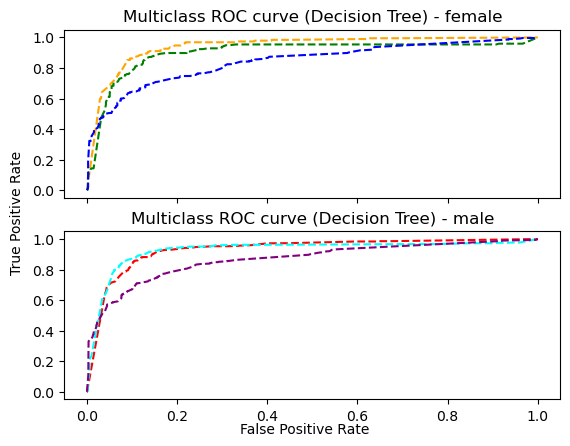

In [142]:
#subplots
fig, (ax1, ax2) = plt.subplots(2,sharex=True)

# plotting, female
ax1.plot(fpr_DT1_female[0], tpr_DT1_female[0], linestyle='--', color='orange', label = f'NORM vs Rest (AUC={AUC_DT1_female[0]:.3f})')
ax1.plot(fpr_DT1_female[1], tpr_DT1_female[1], linestyle='--', color='green', label = f'AFIB vs Rest (AUC={AUC_DT1_female[1]:.3f})')
ax1.plot(fpr_DT1_female[2], tpr_DT1_female[2], linestyle='--', color='blue', label = f'Other vs Rest(AUC={AUC_DT1_female[2]:.3f})')
ax1.set_title('Multiclass ROC curve (Decision Tree) - female')

# plotting, male  
ax2.plot(fpr_DT1_male[0], tpr_DT1_male[0], linestyle='--', color='red', label = f'NORM vs Rest (AUC={AUC_DT1_male[0]:.3f})')
ax2.plot(fpr_DT1_male[1], tpr_DT1_male[1], linestyle='--', color='cyan', label = f'AFIB vs Rest (AUC={AUC_DT1_male[1]:.3f})')
ax2.plot(fpr_DT1_male[2], tpr_DT1_male[2], linestyle='--', color='purple', label = f'Other vs Rest(AUC={AUC_DT1_male[2]:.3f})')

ax2.set_title('Multiclass ROC curve (Decision Tree) - male')
fig.text(0.04, 0.5, 'True Positive Rate', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'False Positive Rate', ha='center')

print(f'AUC (female): {AUC_DT1_female}')
print(f'AUC (male): {AUC_DT1_male}')

### Random Forest

In [143]:
# Implementing classifier

RF = RandomForestClassifier(n_estimators = best_params_RF['n_estimators'], max_depth = best_params_RF['max_depth'])
RF.fit(X_train1_female, y_train1_female)

# testing model 20% female
y_pred_RF1_female = RF.predict(X_test1_female)
y_true_RF1_female = y_test1_female

score1_female = RF.score(X_test1_female, y_test1_female)
print(f"Score for female: {score1_female}")

# testing model 100% male
y_pred_RF1_male = RF.predict(X_test1_male)
y_true_RF1_male = y_test1_male

score1_male = RF.score(X_test1_male, y_test1_male)
print(f"Score for male: {score1_male}")

Score for female: 0.7794336810730254
Score for male: 0.8071544715447154


#### Plots

##### Classification report

In [145]:
#Classification report
target_names = ['NORM', 'AFIB', 'Other']

#female
class_report_RF1_female = classification_report(y_true_RF1_female, y_pred_RF1_female, target_names=target_names)
print(class_report_RF1_female)

#male
class_report_RF1_male = classification_report(y_true_RF1_male, y_pred_RF1_male, target_names=target_names)
print(class_report_RF1_male)

              precision    recall  f1-score   support

        NORM       0.77      0.86      0.82       190
        AFIB       0.78      0.81      0.79       196
       Other       0.79      0.70      0.74       285

    accuracy                           0.78       671
   macro avg       0.78      0.79      0.78       671
weighted avg       0.78      0.78      0.78       671

              precision    recall  f1-score   support

        NORM       0.82      0.88      0.85       999
        AFIB       0.72      0.88      0.79       688
       Other       0.86      0.72      0.78      1388

    accuracy                           0.81      3075
   macro avg       0.80      0.83      0.81      3075
weighted avg       0.82      0.81      0.81      3075



###### Confusion matrix

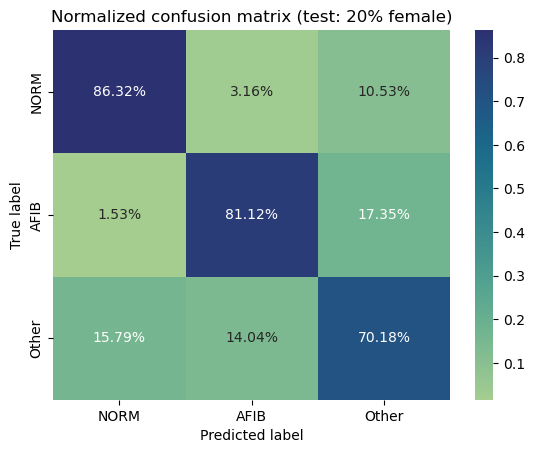

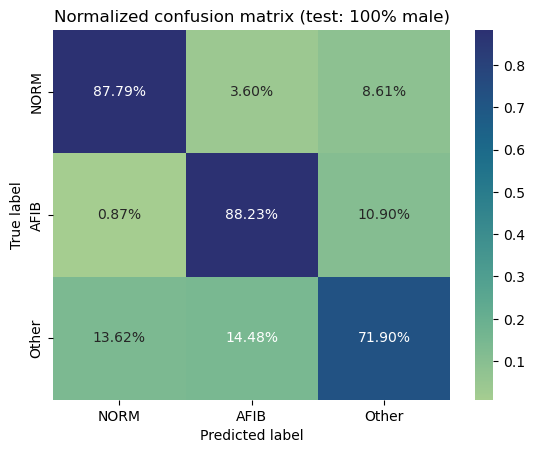

In [147]:
cm_RF1_female = confusion_matrix(y_true_RF1_female, y_pred_RF1_female)
cm_RF1_male = confusion_matrix(y_true_RF1_male, y_pred_RF1_male)

# normalized confusion matrix, female
cm_normalized_RF1_female = cm_RF1_female.astype('float') / cm_RF1_female.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_RF1_female, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (test: 20% female)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

# normalized confusion matrix, male
cm_normalized_RF1_male = cm_RF1_male.astype('float') / cm_RF1_male.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_RF1_male, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (test: 100% male)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

##### ROC-curve + ROC-AUC

In [148]:
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(RF)
clf.fit(X_train1_female, y_train1_female)

#Predict class probabilities of the input
pred_prob_RF1_female = clf.predict_proba(X_test1_female)
pred_prob_RF1_male = clf.predict_proba(X_test1_male)

In [149]:
from sklearn.metrics import auc

# roc curve for classes
fpr_RF1_female = {}
tpr_RF1_female = {}
thresh_RF1_female = {}
AUC_RF1_female = {}

fpr_RF1_male = {}
tpr_RF1_male = {}
thresh_RF1_male = {}
AUC_RF1_male = {}

n_class = 3

#female
for i in range(n_class):    
    fpr_RF1_female[i], tpr_RF1_female[i], thresh_RF1_female[i] = metrics.roc_curve(
                                                                y_test1_female, pred_prob_RF1_female[:,i], pos_label=i)
    AUC_RF1_female[i] = auc(fpr_RF1_female[i], tpr_RF1_female[i])

#male
for i in range(n_class):    
    fpr_RF1_male[i], tpr_RF1_male[i], thresh_RF1_male[i] = metrics.roc_curve(y_test1_male, pred_prob_RF1_male[:,i], pos_label=i)
    AUC_RF1_male[i] = auc(fpr_RF1_male[i], tpr_RF1_male[i])

## female
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_RF1_female[i], tpr_RF1_female[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_RF1_female["macro"] = fpr_grid
tpr_RF1_female["macro"] = mean_tpr
AUC_RF1_female["macro"] = auc(fpr_RF1_female["macro"], tpr_RF1_female["macro"])

## male
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_RF1_male[i], tpr_RF1_male[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_RF1_male["macro"] = fpr_grid
tpr_RF1_male["macro"] = mean_tpr
AUC_RF1_male["macro"] = auc(fpr_RF1_male["macro"], tpr_RF1_male["macro"])

AUC (female): {0: 0.9495677864098916, 1: 0.9412835660580021, 2: 0.8696800290882647, 'macro': 0.9201601282740066}
AUC (male): {0: 0.9417109788015376, 1: 0.9556381587279938, 2: 0.8900177915881577, 'macro': 0.929135635100012}


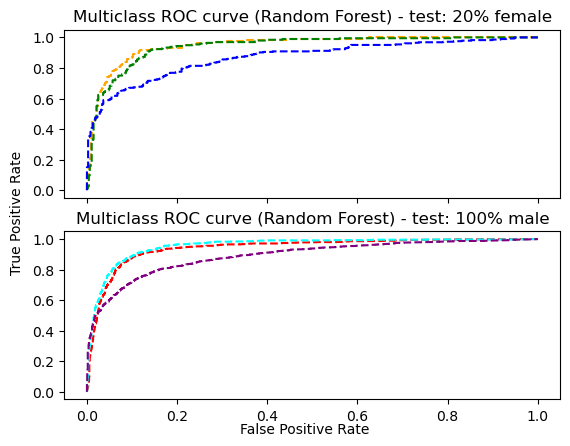

In [151]:
#subplots
fig, (ax1, ax2) = plt.subplots(2,sharex=True)

# plotting, female
ax1.plot(fpr_RF1_female[0], tpr_RF1_female[0], linestyle='--', color='orange', label = f'NORM vs Rest (AUC={AUC_RF1_female[0]:.3f})')
ax1.plot(fpr_RF1_female[1], tpr_RF1_female[1], linestyle='--', color='green', label = f'AFIB vs Rest (AUC={AUC_RF1_female[1]:.3f})')
ax1.plot(fpr_RF1_female[2], tpr_RF1_female[2], linestyle='--', color='blue', label = f'Other vs Rest(AUC={AUC_RF1_female[2]:.3f})')
ax1.set_title('Multiclass ROC curve (Random Forest) - test: 20% female')

# plotting, male  
ax2.plot(fpr_RF1_male[0], tpr_RF1_male[0], linestyle='--', color='red', label = f'NORM vs Rest (AUC={AUC_RF1_male[0]:.3f})')
ax2.plot(fpr_RF1_male[1], tpr_RF1_male[1], linestyle='--', color='cyan', label = f'AFIB vs Rest (AUC={AUC_RF1_male[1]:.3f})')
ax2.plot(fpr_RF1_male[2], tpr_RF1_male[2], linestyle='--', color='purple', label = f'Other vs Rest(AUC={AUC_RF1_male[2]:.3f})')

ax2.set_title('Multiclass ROC curve (Random Forest) - test: 100% male')
fig.text(0.04, 0.5, 'True Positive Rate', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'False Positive Rate', ha='center')

print(f'AUC (female): {AUC_RF1_female}')
print(f'AUC (male): {AUC_RF1_male}')

### AdaBoost

In [152]:
#Adaboost (ensemble)
from sklearn.ensemble import AdaBoostClassifier

# Implementing classifier

ada = AdaBoostClassifier(n_estimators = best_params_ada['n_estimators'])
ada.fit(X_train1_female, y_train1_female)

# testing model 20% female
y_pred_ada1_female = ada.predict(X_test1_female)
y_true_ada1_female = y_test1_female

score1_female = ada.score(X_test1_female, y_test1_female)
print(f"Score for female: {score1_female}")

# testing model 100% male
y_pred_ada1_male = ada.predict(X_test1_male)
y_true_ada1_male = y_test1_male

score1_male = ada.score(X_test1_male, y_test1_male)
print(f"Score for male: {score1_male}")

Score for female: 0.7570789865871833
Score for male: 0.7691056910569106


#### Plots 

###### Classification report

In [154]:
target_names = ['NORM', 'AFIB', 'Other']

#female
class_report_ada1_female = classification_report(y_true_ada1_female, y_pred_ada1_female, target_names=target_names)
print(class_report_ada1_female)

#male
class_report_ada1_male = classification_report(y_true_ada1_male, y_pred_ada1_male, target_names=target_names)
print(class_report_ada1_male)

              precision    recall  f1-score   support

        NORM       0.74      0.86      0.80       190
        AFIB       0.74      0.84      0.79       196
       Other       0.79      0.63      0.70       285

    accuracy                           0.76       671
   macro avg       0.76      0.78      0.76       671
weighted avg       0.76      0.76      0.75       671

              precision    recall  f1-score   support

        NORM       0.77      0.86      0.82       999
        AFIB       0.68      0.89      0.77       688
       Other       0.84      0.64      0.73      1388

    accuracy                           0.77      3075
   macro avg       0.76      0.80      0.77      3075
weighted avg       0.78      0.77      0.77      3075



##### Confusion matrix

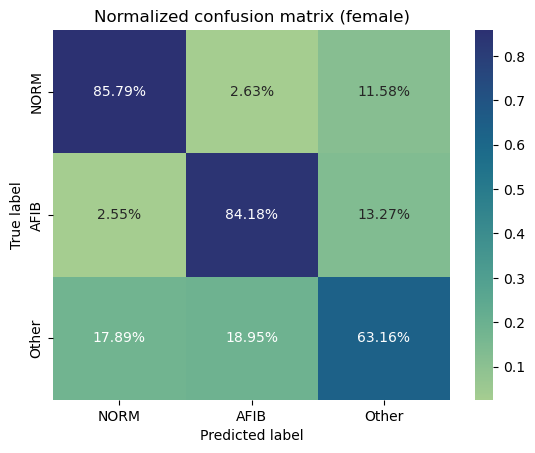

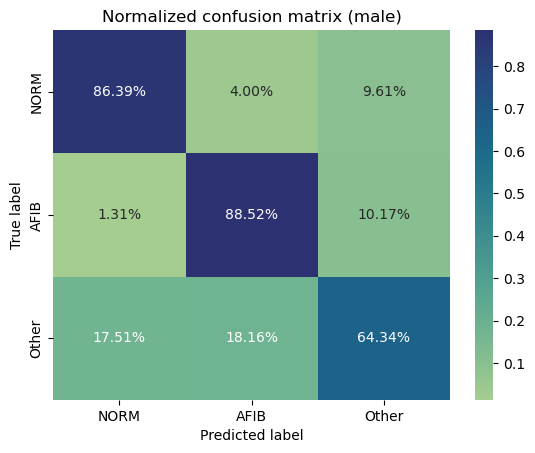

In [157]:
cm_ada1_female = confusion_matrix(y_true_ada1_female, y_pred_ada1_female)
cm_ada1_male = confusion_matrix(y_true_ada1_male, y_pred_ada1_male)

# normalized confusion matrix, female
cm_normalized_ada1_female = cm_ada1_female.astype('float') / cm_ada1_female.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_ada1_female, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (female)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

# normalized confusion matrix, male
cm_normalized_ada1_male = cm_ada1_male.astype('float') / cm_ada1_male.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_ada1_male, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (male)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

##### ROC-curve + ROC-AUC

In [158]:
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(ada)
clf.fit(X_train1_female, y_train1_female)

#Predict class probabilities of the input
pred_prob_ada1_female = clf.predict_proba(X_test1_female)
pred_prob_ada1_male = clf.predict_proba(X_test1_male)

In [159]:
from sklearn.metrics import auc

# roc curve for classes
fpr_ada1_female = {}
tpr_ada1_female = {}
thresh_ada1_female = {}
AUC_ada1_female = {}

fpr_ada1_male = {}
tpr_ada1_male = {}
thresh_ada1_male = {}
AUC_ada1_male = {}

n_class = 3

#female
for i in range(n_class):    
    fpr_ada1_female[i], tpr_ada1_female[i], thresh_ada1_female[i] = metrics.roc_curve(
                                                                y_test1_female, pred_prob_ada1_female[:,i], pos_label=i)
    AUC_ada1_female[i] = auc(fpr_ada1_female[i], tpr_ada1_female[i])

#male
for i in range(n_class):    
    fpr_ada1_male[i], tpr_ada1_male[i], thresh_ada1_male[i] = metrics.roc_curve(y_test1_male, pred_prob_ada1_male[:,i], pos_label=i)
    AUC_ada1_male[i] = auc(fpr_ada1_male[i], tpr_ada1_male[i])
    
## female
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_ada1_female[i], tpr_ada1_female[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_ada1_female["macro"] = fpr_grid
tpr_ada1_female["macro"] = mean_tpr
AUC_ada1_female["macro"] = auc(fpr_ada1_female["macro"], tpr_ada1_female["macro"])

## male
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_ada1_male[i], tpr_ada1_male[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_ada1_male["macro"] = fpr_grid
tpr_ada1_male["macro"] = mean_tpr
AUC_ada1_male["macro"] = auc(fpr_ada1_male["macro"], tpr_ada1_male["macro"])

AUC (female): {0: 0.9167687930845826, 1: 0.8897207303974222, 2: 0.69595945823107, 'macro': 0.8341467886218861}
AUC (female): {0: 0.9167687930845826, 1: 0.8897207303974222, 2: 0.69595945823107, 'macro': 0.8341467886218861}


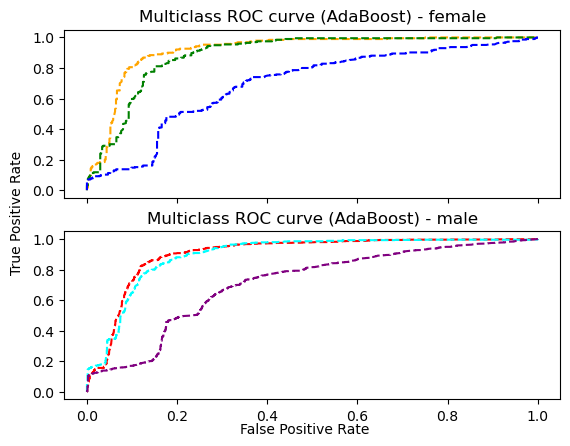

In [161]:
#subplots
fig, (ax1, ax2) = plt.subplots(2,sharex=True)

# plotting, female
ax1.plot(fpr_ada1_female[0], tpr_ada1_female[0], linestyle='--', color='orange', label = f'NORM vs Rest (AUC={AUC_ada1_female[0]:.3f})')
ax1.plot(fpr_ada1_female[1], tpr_ada1_female[1], linestyle='--', color='green', label = f'AFIB vs Rest (AUC={AUC_ada1_female[1]:.3f})')
ax1.plot(fpr_ada1_female[2], tpr_ada1_female[2], linestyle='--', color='blue', label = f'Other vs Rest(AUC={AUC_ada1_female[2]:.3f})')
ax1.set_title('Multiclass ROC curve (AdaBoost) - female')

# plotting, male  
ax2.plot(fpr_ada1_male[0], tpr_ada1_male[0], linestyle='--', color='red', label = f'NORM vs Rest (AUC={AUC_ada1_male[0]:.3f})')
ax2.plot(fpr_ada1_male[1], tpr_ada1_male[1], linestyle='--', color='cyan', label = f'AFIB vs Rest (AUC={AUC_ada1_male[1]:.3f})')
ax2.plot(fpr_ada1_male[2], tpr_ada1_male[2], linestyle='--', color='purple', label = f'Other vs Rest(AUC={AUC_ada1_male[2]:.3f})')

ax2.set_title('Multiclass ROC curve (AdaBoost) - male')
fig.text(0.04, 0.5, 'True Positive Rate', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'False Positive Rate', ha='center')

print(f'AUC (female): {AUC_ada1_female}')
print(f'AUC (female): {AUC_ada1_female}')

### EVC

#### Hard voting

In [163]:
# Implementing classifier

EVCh = VotingClassifier(
    estimators = [
        ('KNN', KNN), 
        ('DT', DT), 
        ('RF',RF),
        ('Ada', ada)], 
         voting ='hard')
EVCh.fit(X_train1_female, y_train1_female)

# testing model 20% female
y_pred_EVCh1_female = EVCh.predict(X_test1_female)
y_true_EVCh1_female = y_test1_female

score1_female = EVCh.score(X_test1_female, y_test1_female)
print(f"Score for female: {score1_female}")

# testing model 100% male
y_pred_EVCh1_male = EVCh.predict(X_test1_male)
y_true_EVCh1_male = y_test1_male

score1_male = EVCh.score(X_test1_male, y_test1_male)
print(f"Score for male: {score1_male}")

Score for female: 0.7794336810730254
Score for male: 0.7856910569105691


##### Classification report

In [164]:
#Classification report
target_names = ['NORM', 'AFIB', 'Other']

#female
class_report_EVCh1_female = classification_report(y_true_EVCh1_female, y_pred_EVCh1_female, target_names=target_names)
print(class_report_EVCh1_female)

#male
class_report_EVCh1_male = classification_report(y_true_EVCh1_male, y_pred_EVCh1_male, target_names=target_names)
print(class_report_EVCh1_male)

              precision    recall  f1-score   support

        NORM       0.76      0.88      0.82       190
        AFIB       0.75      0.85      0.80       196
       Other       0.82      0.66      0.73       285

    accuracy                           0.78       671
   macro avg       0.78      0.80      0.78       671
weighted avg       0.79      0.78      0.78       671

              precision    recall  f1-score   support

        NORM       0.79      0.88      0.83       999
        AFIB       0.68      0.91      0.78       688
       Other       0.87      0.66      0.75      1388

    accuracy                           0.79      3075
   macro avg       0.78      0.81      0.79      3075
weighted avg       0.80      0.79      0.78      3075



##### Confusion matrix

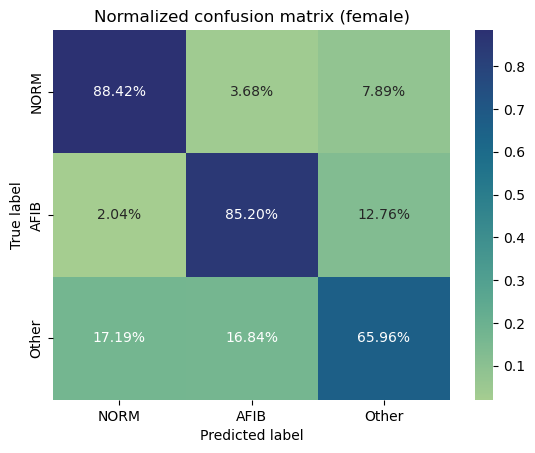

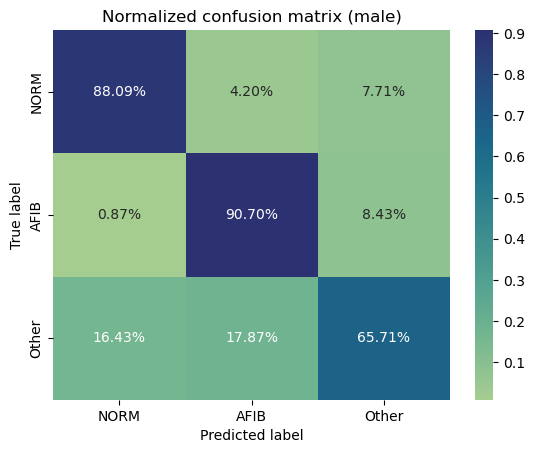

In [174]:
cm_EVCh1_female = confusion_matrix(y_true_EVCh1_female, y_pred_EVCh1_female)
cm_EVCh1_male = confusion_matrix(y_true_EVCh1_male, y_pred_EVCh1_male)

# normalized confusion matrix, female
cm_normalized_EVCh1_female = cm_EVCh1_female.astype('float') / cm_EVCh1_female.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_EVCh1_female, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (female)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

# normalized confusion matrix, male
cm_normalized_EVCh1_male = cm_EVCh1_male.astype('float') / cm_EVCh1_male.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_EVCh1_male, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (male)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

##### ROC-curve + ROC-AUC

In [166]:
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(EVCs)
clf.fit(X_train1_female, y_train1_female)

#Predict class probabilities of the input
pred_prob_EVCh1_female = clf.predict_proba(X_test1_female)
pred_prob_EVCh1_male = clf.predict_proba(X_test1_male)

In [167]:
from sklearn.metrics import auc
# roc curve for classes
fpr_EVCh1_female = {}
tpr_EVCh1_female = {}
thresh_EVCh1_female = {}
AUC_EVCh1_female = {}

fpr_EVCh1_male = {}
tpr_EVCh1_male = {}
thresh_EVCh1_male = {}
AUC_EVCh1_male = {}

n_class = 3

#female
for i in range(n_class):    
    fpr_EVCh1_female[i], tpr_EVCh1_female[i], thresh_EVCh1_female[i] = metrics.roc_curve(
                                                                    y_test1_female, pred_prob_EVCh1_female[:,i], pos_label=i)
    AUC_EVCh1_female[i] = auc(fpr_EVCh1_female[i], tpr_EVCh1_female[i])

#male
for i in range(n_class):    
    fpr_EVCh1_male[i], tpr_EVCh1_male[i], thresh_EVCh1_male[i] = metrics.roc_curve(
                                                                    y_test1_male, pred_prob_EVCh1_male[:,i], pos_label=i)
    AUC_EVCh1_male[i] = auc(fpr_EVCh1_male[i], tpr_EVCh1_male[i])

## female
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_EVCh1_female[i], tpr_EVCh1_female[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_EVCh1_female["macro"] = fpr_grid
tpr_EVCh1_female["macro"] = mean_tpr
AUC_EVCh1_female["macro"] = auc(fpr_EVCh1_female["macro"], tpr_EVCh1_female["macro"])

## male
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_EVCh1_male[i], tpr_EVCh1_male[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_EVCh1_male["macro"] = fpr_grid
tpr_EVCh1_male["macro"] = mean_tpr
AUC_EVCh1_male["macro"] = auc(fpr_EVCh1_male["macro"], tpr_EVCh1_male["macro"])

Text(0.5, 0.04, 'False Positive Rate')

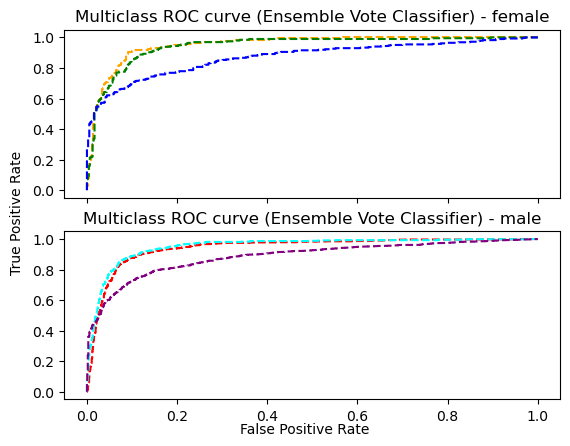

In [169]:
#subplots
fig, (ax1, ax2) = plt.subplots(2,sharex=True)

# plotting, female
ax1.plot(fpr_EVCh1_female[0], tpr_EVCh1_female[0], linestyle='--', color='orange', label = f'NORM vs Rest (AUC={AUC_EVCh1_female[0]:.3f})')
ax1.plot(fpr_EVCh1_female[1], tpr_EVCh1_female[1], linestyle='--', color='green', label = f'AFIB vs Rest (AUC={AUC_EVCh1_female[1]:.3f})')
ax1.plot(fpr_EVCh1_female[2], tpr_EVCh1_female[2], linestyle='--', color='blue', label = f'Other vs Rest(AUC={AUC_EVCh1_female[2]:.3f})')
ax1.set_title('Multiclass ROC curve (Ensemble Vote Classifier) - female')

# plotting, male
ax2.plot(fpr_EVCh1_male[0], tpr_EVCh1_male[0], linestyle='--', color='red', label = f'NORM vs Rest (AUC={AUC_EVCh1_male[0]:.3f})')
ax2.plot(fpr_EVCh1_male[1], tpr_EVCh1_male[1], linestyle='--', color='cyan', label = f'AFIB vs Rest (AUC={AUC_EVCh1_male[1]:.3f})')
ax2.plot(fpr_EVCh1_male[2], tpr_EVCh1_male[2], linestyle='--', color='purple', label = f'Other vs Rest(AUC={AUC_EVCh1_male[2]:.3f})')

ax2.set_title('Multiclass ROC curve (Ensemble Vote Classifier) - male')
fig.text(0.04, 0.5, 'True Positive Rate', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'False Positive Rate', ha='center')

#### Soft voting

In [170]:
# Implementing classifier

EVCs = VotingClassifier(estimators = [('KNN', KNN), ('DT', DT), ('RF',RF), ('Ada', ada)], voting ='soft')
EVCs.fit(X_train1_female, y_train1_female)
    
# testing model 20% female
y_pred_EVCs1_female = EVCs.predict(X_test1_female)
y_true_EVCs1_female = y_test1_female

score1_female = EVCs.score(X_test1_female, y_test1_female)
print(f"Score for female: {score1_female}")

# testing model 100% male
y_pred_EVCs1_male = EVCs.predict(X_test1_male)
y_true_EVCs1_male = y_test1_male

score1_male = EVCs.score(X_test1_male, y_test1_male)
print(f"Score for male: {score1_male}")

Score for female: 0.8017883755588674
Score for male: 0.7986991869918699


##### Classification report

In [171]:
#Classification report
target_names = ['NORM', 'AFIB', 'Other']

#female
class_report_EVCs1_female = classification_report(y_true_EVCs1_female, y_pred_EVCs1_female, target_names=target_names)
print(class_report_EVCs1_female)

#male
class_report_EVCs1_male = classification_report(y_true_EVCs1_male, y_pred_EVCs1_male, target_names=target_names)
print(class_report_EVCs1_male)

              precision    recall  f1-score   support

        NORM       0.80      0.88      0.84       190
        AFIB       0.79      0.81      0.80       196
       Other       0.81      0.74      0.77       285

    accuracy                           0.80       671
   macro avg       0.80      0.81      0.81       671
weighted avg       0.80      0.80      0.80       671

              precision    recall  f1-score   support

        NORM       0.81      0.87      0.84       999
        AFIB       0.71      0.88      0.79       688
       Other       0.85      0.70      0.77      1388

    accuracy                           0.80      3075
   macro avg       0.79      0.82      0.80      3075
weighted avg       0.81      0.80      0.80      3075



##### Confusion matrix

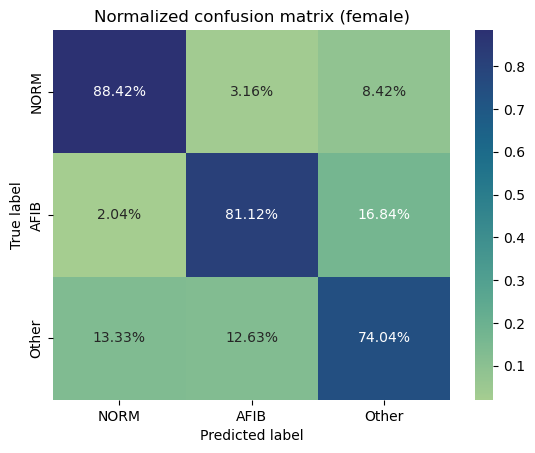

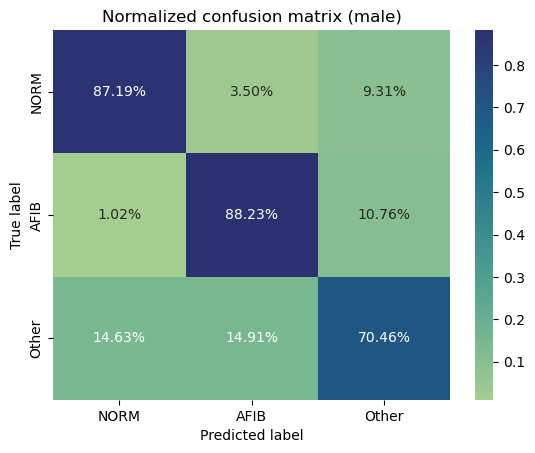

In [173]:
cm_EVCs1_female = confusion_matrix(y_true_EVCs1_female, y_pred_EVCs1_female)
cm_EVCs1_male = confusion_matrix(y_true_EVCs1_male, y_pred_EVCs1_male)

# normalized confusion matrix, female
cm_normalized_EVCs1_female = cm_EVCs1_female.astype('float') / cm_EVCs1_female.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_EVCs1_female, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (female)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

# normalized confusion matrix, male
cm_normalized_EVCs1_male = cm_EVCs1_male.astype('float') / cm_EVCs1_male.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_EVCs1_male, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (male)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

##### ROC-curve + ROC-AUC

In [175]:
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier


# clf = OneVsRestClassifier(EVCs)
clf.fit(X_train1_female, y_train1_female)

#Predict class probabilities of the input
pred_prob_EVCs1_female = clf.predict_proba(X_test1_female)
pred_prob_EVCs1_male = clf.predict_proba(X_test1_male)

In [176]:
from sklearn.metrics import auc
# roc curve for classes
fpr_EVCs1_female = {}
tpr_EVCs1_female = {}
thresh_EVCs1_female = {}
AUC_EVCs1_female = {}

fpr_EVCs1_male = {}
tpr_EVCs1_male = {}
thresh_EVCs1_male = {}
AUC_EVCs1_male = {}

n_class = 3

#female
for i in range(n_class):    
    fpr_EVCs1_female[i], tpr_EVCs1_female[i], thresh_EVCs1_female[i] = metrics.roc_curve(
                                                                y_test1_female, pred_prob_EVCs1_female[:,i], pos_label=i)
    AUC_EVCs1_female[i] = auc(fpr_EVCs1_female[i], tpr_EVCs1_female[i])

#male
for i in range(n_class):    
    fpr_EVCs1_male[i], tpr_EVCs1_male[i], thresh_EVCs1_male[i] = metrics.roc_curve(y_test1_male, pred_prob_EVCs1_male[:,i], pos_label=i)
    AUC_EVCs1_male[i] = auc(fpr_EVCs1_male[i], tpr_EVCs1_male[i])

## female
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_EVCs1_female[i], tpr_EVCs1_female[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_EVCs1_female["macro"] = fpr_grid
tpr_EVCs1_female["macro"] = mean_tpr
AUC_EVCs1_female["macro"] = auc(fpr_EVCs1_female["macro"], tpr_EVCs1_female["macro"])

## male
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_EVCs1_male[i], tpr_EVCs1_male[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_EVCs1_male["macro"] = fpr_grid
tpr_EVCs1_male["macro"] = mean_tpr
AUC_EVCs1_male["macro"] = auc(fpr_EVCs1_male["macro"], tpr_EVCs1_male["macro"])

AUC (female): {0: 0.9537367326841011, 1: 0.944484425349087, 2: 0.8721434415053178, 'macro': 0.9234241094349324}
AUC (female): {0: 0.943399083090798, 1: 0.9538515919564307, 2: 0.8850539982814847, 'macro': 0.9274603524985037}


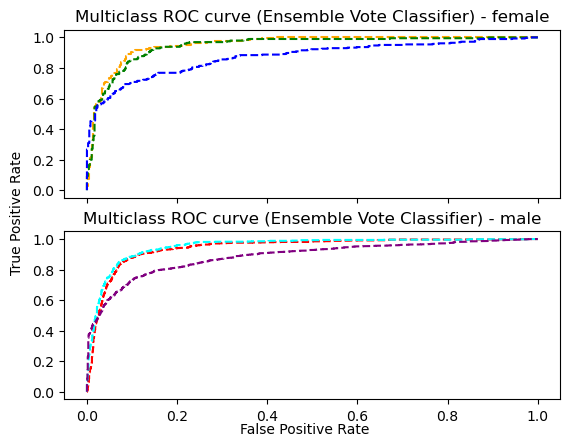

In [178]:
#subplots
fig, (ax1, ax2) = plt.subplots(2,sharex=True)

# plotting, female
ax1.plot(fpr_EVCs1_female[0], tpr_EVCs1_female[0], linestyle='--', color='orange', label = f'NORM vs Rest (AUC={AUC_EVCs1_female[0]:.3f})')
ax1.plot(fpr_EVCs1_female[1], tpr_EVCs1_female[1], linestyle='--', color='green', label = f'AFIB vs Rest (AUC={AUC_EVCs1_female[1]:.3f})')
ax1.plot(fpr_EVCs1_female[2], tpr_EVCs1_female[2], linestyle='--', color='blue', label = f'Other vs Rest(AUC={AUC_EVCs1_female[2]:.3f})')
ax1.set_title('Multiclass ROC curve (Ensemble Vote Classifier) - female')

# plotting, male
ax2.plot(fpr_EVCs1_male[0], tpr_EVCs1_male[0], linestyle='--', color='red', label = f'NORM vs Rest (AUC={AUC_EVCs1_male[0]:.3f})')
ax2.plot(fpr_EVCs1_male[1], tpr_EVCs1_male[1], linestyle='--', color='cyan', label = f'AFIB vs Rest (AUC={AUC_EVCs1_male[1]:.3f})')
ax2.plot(fpr_EVCs1_male[2], tpr_EVCs1_male[2], linestyle='--', color='purple', label = f'Other vs Rest(AUC={AUC_EVCs1_male[2]:.3f})')

ax2.set_title('Multiclass ROC curve (Ensemble Vote Classifier) - male')
fig.text(0.04, 0.5, 'True Positive Rate', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'False Positive Rate', ha='center')

print(f'AUC (female): {AUC_EVCs1_female}')
print(f'AUC (female): {AUC_EVCs1_male}')

## Train: 80% male , Test: 20% male + 100% female

### Splitting into train and test set

In [179]:
from sklearn.model_selection import train_test_split
#splitting male
X_male = df2_male.drop(['Label'], axis = 1)
y_male = df2_male['Label']

X_train2_male, X_test2_male, y_train2_male, y_test2_male = train_test_split(X_male, y_male, test_size = 0.2, shuffle = True)

# sorting female
X_female = df2_female.drop(['Label'], axis = 1)
y_female = df2_female['Label']

X_test2_female = X_female
y_test2_female = y_female

### KNN

In [180]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# train model + find the best fit model
KNN = KNeighborsClassifier(n_neighbors = best_params_KNN['n_neighbors'], weights = best_params_KNN['weights'])
KNN.fit(X_train2_male, y_train2_male)

# testing model 20% male
y_pred_KNN2_male = KNN.predict(X_test2_male)
y_true_KNN2_male = y_test2_male

score2_male = KNN.score(X_test2_male, y_test2_male)
print(f"Score for male: {score2_male}")

# testing model 100% female
y_pred_KNN2_female = KNN.predict(X_test2_female)
y_true_KNN2_female = y_test2_female

score2_female = KNN.score(X_test2_female, y_test2_female)
print(f"Score for female: {score2_female}")

Score for male: 0.7934959349593496
Score for female: 0.7903370116313749


##### Classification report

In [181]:
target_names = ['NORM', 'AFIB', 'Other']

#male
class_report_KNN2_male = classification_report(y_true_KNN2_male, y_pred_KNN2_male, target_names=target_names)
print(class_report_KNN2_male)

#female
class_report_KNN2_female = classification_report(y_true_KNN2_female, y_pred_KNN2_female, target_names=target_names)
print(class_report_KNN2_female)

              precision    recall  f1-score   support

        NORM       0.82      0.84      0.83       212
        AFIB       0.77      0.77      0.77       131
       Other       0.79      0.76      0.78       272

    accuracy                           0.79       615
   macro avg       0.79      0.79      0.79       615
weighted avg       0.79      0.79      0.79       615

              precision    recall  f1-score   support

        NORM       0.78      0.85      0.82      1001
        AFIB       0.81      0.80      0.80       899
       Other       0.78      0.74      0.76      1453

    accuracy                           0.79      3353
   macro avg       0.79      0.80      0.79      3353
weighted avg       0.79      0.79      0.79      3353



##### Confusion matrix

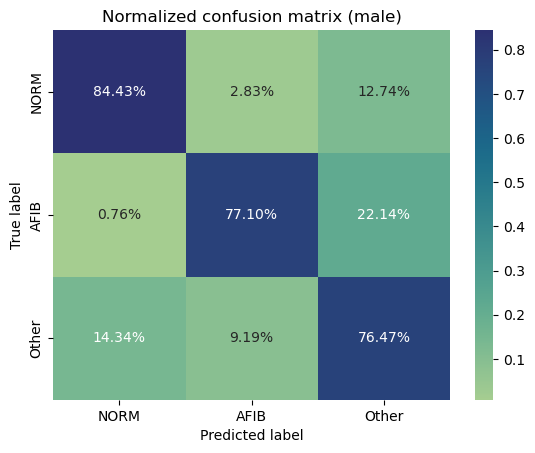

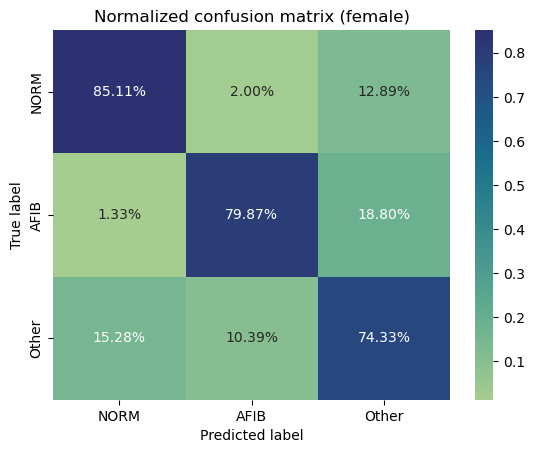

In [183]:
cm_KNN2_male = confusion_matrix(y_true_KNN2_male, y_pred_KNN2_male)
cm_KNN2_female = confusion_matrix(y_true_KNN2_female, y_pred_KNN2_female)

# normalized confusion matrix, male
cm_normalized_KNN2_male = cm_KNN2_male.astype('float') / cm_KNN2_male.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_KNN2_male, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (male)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

# normalized confusion matrix, female
cm_normalized_KNN2_female = cm_KNN2_female.astype('float') / cm_KNN2_female.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_KNN2_female, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (female)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

##### ROC-curve + ROC-AUC

In [184]:
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

#taget det sidste fold - overvej om det skal tages for det bedste fold
clf = OneVsRestClassifier(KNN)
clf.fit(X_train2_male, y_train2_male)

#Predict class probabilities of the input
pred_prob_KNN2_female = clf.predict_proba(X_test2_female)
pred_prob_KNN2_male = clf.predict_proba(X_test2_male)

In [185]:
from sklearn.metrics import auc

# roc curve for classes
fpr_KNN2_male = {}
tpr_KNN2_male = {}
thresh_KNN2_male = {}
AUC_KNN2_male = {}

fpr_KNN2_female = {}
tpr_KNN2_female = {}
thresh_KNN2_female = {}
AUC_KNN2_female = {}

n_class = 3

#male
for i in range(n_class):    
    fpr_KNN2_male[i], tpr_KNN2_male[i], thresh_KNN2_male[i] = metrics.roc_curve(y_test2_male, pred_prob_KNN2_male[:,i], pos_label=i)
    AUC_KNN2_male[i] = auc(fpr_KNN2_male[i], tpr_KNN2_male[i])
    
#female
for i in range(n_class):    
    fpr_KNN2_female[i], tpr_KNN2_female[i], thresh_KNN2_female[i] = metrics.roc_curve(y_test2_female, pred_prob_KNN2_female[:,i], pos_label=i)
    AUC_KNN2_female[i] = auc(fpr_KNN2_female[i], tpr_KNN2_female[i])

## male
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_KNN2_male[i], tpr_KNN2_male[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_KNN2_male["macro"] = fpr_grid
tpr_KNN2_male["macro"] = mean_tpr
AUC_KNN2_male["macro"] = auc(fpr_KNN2_male["macro"], tpr_KNN2_male["macro"])

## female
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_KNN2_female[i], tpr_KNN2_female[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_KNN2_female["macro"] = fpr_grid
tpr_KNN2_female["macro"] = mean_tpr
AUC_KNN2_female["macro"] = auc(fpr_KNN2_female["macro"], tpr_KNN2_female["macro"])

AUC (male): {0: 0.9326220796853786, 1: 0.9271654785187053, 2: 0.8639759475218659, 'macro': 0.9079188864840698}
AUC (male): {0: 0.9318850792065078, 1: 0.9333670573026445, 2: 0.8524750968957149, 'macro': 0.905915968379469}


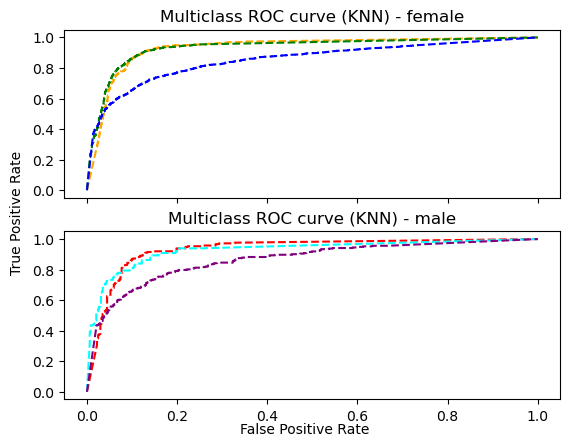

In [186]:
fig, (ax1, ax2) = plt.subplots(2,sharex=True)

# plotting, female
ax1.plot(fpr_KNN2_female[0], tpr_KNN2_female[0], linestyle='--', color='orange', label = f'NORM vs Rest (AUC={AUC_KNN2_female[0]:.3f})')
ax1.plot(fpr_KNN2_female[1], tpr_KNN2_female[1], linestyle='--', color='green', label = f'AFIB vs Rest (AUC={AUC_KNN2_female[1]:.3f})')
ax1.plot(fpr_KNN2_female[2], tpr_KNN2_female[2], linestyle='--', color='blue', label = f'Other vs Rest(AUC={AUC_KNN2_female[2]:.3f})')
ax1.set_title('Multiclass ROC curve (KNN) - female')

# plotting, male  
ax2.plot(fpr_KNN2_male[0], tpr_KNN2_male[0], linestyle='--', color='red', label = f'NORM vs Rest (AUC={AUC_KNN2_male[0]:.3f})')
ax2.plot(fpr_KNN2_male[1], tpr_KNN2_male[1], linestyle='--', color='cyan', label = f'AFIB vs Rest (AUC={AUC_KNN2_male[1]:.3f})')
ax2.plot(fpr_KNN2_male[2], tpr_KNN2_male[2], linestyle='--', color='purple', label = f'Other vs Rest(AUC={AUC_KNN2_male[2]:.3f})')

ax2.set_title('Multiclass ROC curve (KNN) - male')
fig.text(0.04, 0.5, 'True Positive Rate', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'False Positive Rate', ha='center')

print(f'AUC (male): {AUC_KNN2_male}')
print(f'AUC (male): {AUC_KNN2_female}')

### Decision Tree

In [187]:
# Implementing classifier
DT = DecisionTreeClassifier(max_depth = best_params_DT['max_depth'])
DT.fit(X_train2_male, y_train2_male)
    
# testing model 20% male
y_pred_DT2_male = DT.predict(X_test2_male)
y_true_DT2_male = y_test2_male

score2_male = DT.score(X_test2_male, y_test2_male)
print(f"Score for male: {score2_male}")
    
# testing model 100% female
y_pred_DT2_female = DT.predict(X_test2_female)
y_true_DT2_female = y_test2_female

score2_female = DT.score(X_test2_female, y_test2_female)
print(f"Score for female: {score2_female}")

Score for male: 0.7886178861788617
Score for female: 0.7819862809424396


##### Classification report

In [189]:
#Classification report
target_names = ['NORM', 'AFIB', 'Other']

#male
class_report_DT2_male = classification_report(y_true_DT2_male, y_pred_DT2_male, target_names=target_names)
print(class_report_DT2_male)

#female
class_report_DT2_female = classification_report(y_true_DT2_female, y_pred_DT2_female, target_names=target_names)
print(class_report_DT2_female)

              precision    recall  f1-score   support

        NORM       0.85      0.83      0.84       212
        AFIB       0.71      0.78      0.74       131
       Other       0.78      0.76      0.77       272

    accuracy                           0.79       615
   macro avg       0.78      0.79      0.79       615
weighted avg       0.79      0.79      0.79       615

              precision    recall  f1-score   support

        NORM       0.80      0.83      0.81      1001
        AFIB       0.79      0.79      0.79       899
       Other       0.77      0.74      0.75      1453

    accuracy                           0.78      3353
   macro avg       0.78      0.79      0.79      3353
weighted avg       0.78      0.78      0.78      3353



##### Confusion matrix

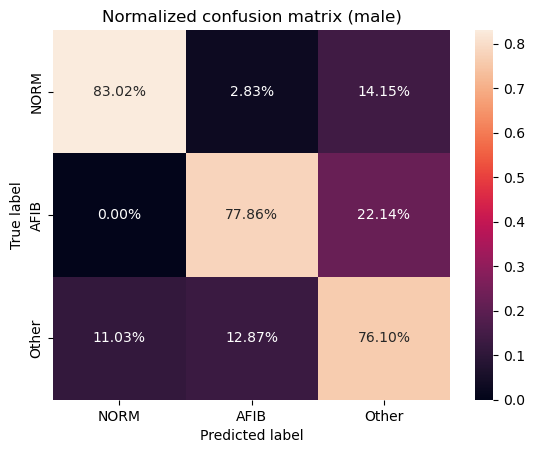

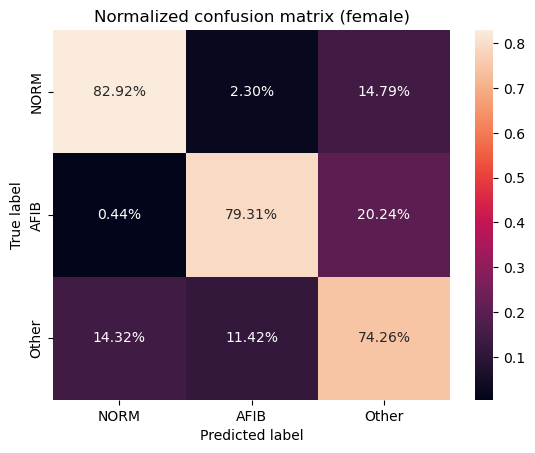

In [190]:
cm_DT2_male = confusion_matrix(y_true_DT2_male, y_pred_DT2_male)
cm_DT2_female = confusion_matrix(y_true_DT2_female, y_pred_DT2_female)

# normalized confusion matrix, male
cm_normalized_DT2_male = cm_DT2_male.astype('float') / cm_DT2_male.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_DT2_male, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names)
ax.set_title('Normalized confusion matrix (male)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()
# normalized confusion matrix, female
cm_normalized_DT2_female = cm_DT2_female.astype('float') / cm_DT2_female.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_DT2_female, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names)
ax.set_title('Normalized confusion matrix (female)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

##### ROC-curve + ROC-AUC

In [191]:
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(DT)
clf.fit(X_train2_male, y_train2_male)

#Predict class probabilities of the input
pred_prob_DT2_female = clf.predict_proba(X_test2_female)
pred_prob_DT2_male = clf.predict_proba(X_test2_male)

In [192]:
from sklearn.metrics import auc

# roc curve for classes
fpr_DT2_female = {}
tpr_DT2_female = {}
thresh_DT2_female = {}
AUC_DT2_female = {}

fpr_DT2_male = {}
tpr_DT2_male = {}
thresh_DT2_male = {}
AUC_DT2_male = {}

n_class = 3

#male
for i in range(n_class):    
    fpr_DT2_male[i], tpr_DT2_male[i], thresh_DT2_male[i] = metrics.roc_curve(y_test2_male, pred_prob_DT2_male[:,i], pos_label=i)
    AUC_DT2_male[i] = auc(fpr_DT2_male[i], tpr_DT2_male[i])
    
#female
for i in range(n_class):    
    fpr_DT2_female[i], tpr_DT2_female[i], thresh_DT2_female[i] = metrics.roc_curve(y_test2_female, pred_prob_DT2_female[:,i], pos_label=i)
    AUC_DT2_female[i] = auc(fpr_DT2_female[i], tpr_DT2_female[i])

## male
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)
for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_DT2_male[i], tpr_DT2_male[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_DT2_male["macro"] = fpr_grid
tpr_DT2_male["macro"] = mean_tpr
AUC_DT2_male["macro"] = auc(fpr_DT2_male["macro"], tpr_DT2_male["macro"])

## female
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)
for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_DT2_female[i], tpr_DT2_female[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_DT2_female["macro"] = fpr_grid
tpr_DT2_female["macro"] = mean_tpr
AUC_DT2_female["macro"] = auc(fpr_DT2_female["macro"], tpr_DT2_female["macro"])

AUC (male): {0: 0.9231412987499412, 1: 0.892830105356129, 2: 0.8536432430114902, 'macro': 0.8898691036141739}
AUC (male): {0: 0.924128380123278, 1: 0.9026286111617272, 2: 0.8361330459666027, 'macro': 0.8876352783405046}


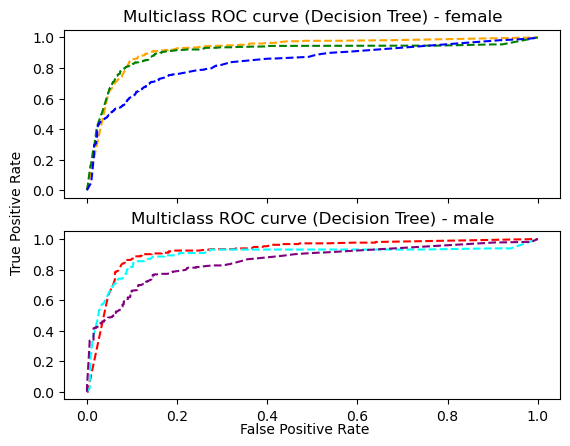

In [193]:
#subplots
fig, (ax1, ax2) = plt.subplots(2,sharex=True)

# plotting, male  
ax2.plot(fpr_DT2_male[0], tpr_DT2_male[0], linestyle='--', color='red', label = f'NORM vs Rest (AUC={AUC_DT2_male[0]:.3f})')
ax2.plot(fpr_DT2_male[1], tpr_DT2_male[1], linestyle='--', color='cyan', label = f'AFIB vs Rest (AUC={AUC_DT2_male[1]:.3f})')
ax2.plot(fpr_DT2_male[2], tpr_DT2_male[2], linestyle='--', color='purple', label = f'Other vs Rest(AUC={AUC_DT2_male[2]:.3f})')
ax2.set_title('Multiclass ROC curve (Decision Tree) - male')

# plotting, female
ax1.plot(fpr_DT2_female[0], tpr_DT2_female[0], linestyle='--', color='orange', label = f'NORM vs Rest (AUC={AUC_DT2_female[0]:.3f})')
ax1.plot(fpr_DT2_female[1], tpr_DT2_female[1], linestyle='--', color='green', label = f'AFIB vs Rest (AUC={AUC_DT2_female[1]:.3f})')
ax1.plot(fpr_DT2_female[2], tpr_DT2_female[2], linestyle='--', color='blue', label = f'Other vs Rest(AUC={AUC_DT2_female[2]:.3f})')
ax1.set_title('Multiclass ROC curve (Decision Tree) - female')


fig.text(0.04, 0.5, 'True Positive Rate', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'False Positive Rate', ha='center')

print(f'AUC (male): {AUC_DT2_male}')
print(f'AUC (male): {AUC_DT2_female}')

### Random Forest

In [194]:
# Implementing classifier
RF = RandomForestClassifier(n_estimators = best_params_RF['n_estimators'],max_depth = best_params_RF['max_depth'])
RF.fit(X_train2_male, y_train2_male)

# testing model 20% male
y_pred_RF2_male = RF.predict(X_test2_male)
y_true_RF2_male = y_test2_male

score2_male = RF.score(X_test2_male, y_test2_male)
print(f"Score for male: {score2_male}")

# testing model 100% female
y_pred_RF2_female = RF.predict(X_test2_female)
y_true_RF2_female = y_test2_female

score2_female = RF.score(X_test2_female, y_test2_female)
print(f"Score for female: {score2_female}")

Score for male: 0.8065040650406504
Score for female: 0.7855651655234118


##### Classification report

In [195]:
#Classification report
target_names = ['NORM', 'AFIB', 'Other']
#male
class_report_RF2_male = classification_report(y_true_RF2_male, y_pred_RF2_male, target_names=target_names)
print(class_report_RF2_male)

#female
class_report_RF2_female = classification_report(y_true_RF2_female, y_pred_RF2_female, target_names=target_names)
print(class_report_RF2_female)

              precision    recall  f1-score   support

        NORM       0.85      0.87      0.86       212
        AFIB       0.74      0.79      0.76       131
       Other       0.80      0.77      0.79       272

    accuracy                           0.81       615
   macro avg       0.80      0.81      0.80       615
weighted avg       0.81      0.81      0.81       615

              precision    recall  f1-score   support

        NORM       0.79      0.85      0.82      1001
        AFIB       0.81      0.77      0.79       899
       Other       0.77      0.75      0.76      1453

    accuracy                           0.79      3353
   macro avg       0.79      0.79      0.79      3353
weighted avg       0.79      0.79      0.79      3353



##### Confusion matrix

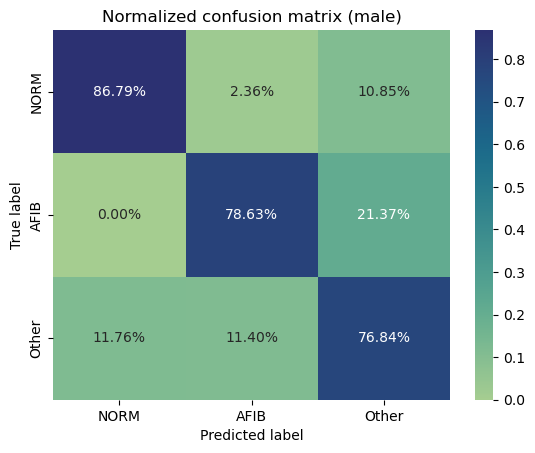

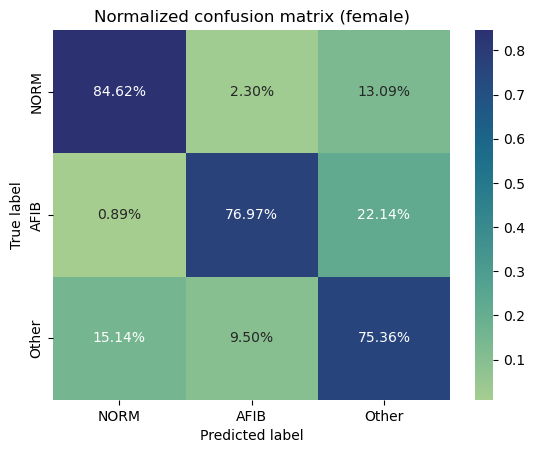

In [196]:
cm_RF2_male = confusion_matrix(y_true_RF2_male, y_pred_RF2_male)
cm_RF2_female = confusion_matrix(y_true_RF2_female, y_pred_RF2_female)
# normalized confusion matrix, male
cm_normalized_RF2_male = cm_RF2_male.astype('float') / cm_RF2_male.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_RF2_male, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (male)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

# normalized confusion matrix, female
cm_normalized_RF2_female = cm_RF2_female.astype('float') / cm_RF2_female.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_RF2_female, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (female)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

##### ROC-curve + ROC-AUC

In [197]:
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(RF)
clf.fit(X_train2_male, y_train2_male)

#Predict class probabilities of the input
pred_prob_RF2_female = clf.predict_proba(X_test2_female)
pred_prob_RF2_male = clf.predict_proba(X_test2_male)

In [198]:
from sklearn.metrics import auc

# roc curve for classes
fpr_RF2_male = {}
tpr_RF2_male = {}
thresh_RF2_male = {}
AUC_RF2_male = {}

fpr_RF2_female = {}
tpr_RF2_female = {}
thresh_RF2_female = {}
AUC_RF2_female = {}

n_class = 3

#male
for i in range(n_class):    
    fpr_RF2_male[i], tpr_RF2_male[i], thresh_RF2_male[i] = metrics.roc_curve(y_test2_male, pred_prob_RF2_male[:,i], pos_label=i)
    AUC_RF2_male[i] = auc(fpr_RF2_male[i], tpr_RF2_male[i])
    
#female
for i in range(n_class):    
    fpr_RF2_female[i], tpr_RF2_female[i], thresh_RF2_female[i] = metrics.roc_curve(
                                                                y_test2_female, pred_prob_RF2_female[:,i], pos_label=i)
    AUC_RF2_female[i] = auc(fpr_RF2_female[i], tpr_RF2_female[i])

## male
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_RF2_male[i], tpr_RF2_male[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_RF2_male["macro"] = fpr_grid
tpr_RF2_male["macro"] = mean_tpr
AUC_RF2_male["macro"] = auc(fpr_RF2_male["macro"], tpr_RF2_male["macro"])
    
## female
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_RF2_female[i], tpr_RF2_female[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_RF2_female["macro"] = fpr_grid
tpr_RF2_female["macro"] = mean_tpr
AUC_RF2_female["macro"] = auc(fpr_RF2_female["macro"], tpr_RF2_female["macro"])

AUC (male): {0: 0.949939135727328, 1: 0.9455002838937605, 2: 0.8846842308351911, 'macro': 0.9267147319058621}
AUC (male): {0: 0.9406660516354395, 1: 0.9448370597412865, 2: 0.8628701054080486, 'macro': 0.9161116337327115}


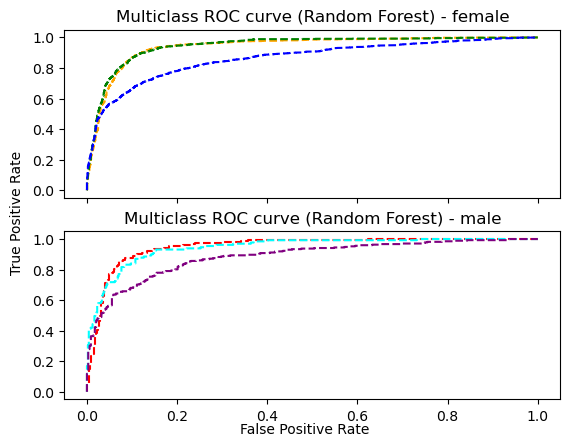

In [199]:
#subplots
fig, (ax1, ax2) = plt.subplots(2,sharex=True)

# plotting, male  
ax2.plot(fpr_RF2_male[0], tpr_RF2_male[0], linestyle='--', color='red', label = f'NORM vs Rest (AUC={AUC_RF2_male[0]:.3f})')
ax2.plot(fpr_RF2_male[1], tpr_RF2_male[1], linestyle='--', color='cyan', label = f'AFIB vs Rest (AUC={AUC_RF2_male[1]:.3f})')
ax2.plot(fpr_RF2_male[2], tpr_RF2_male[2], linestyle='--', color='purple', label = f'Other vs Rest(AUC={AUC_RF2_male[2]:.3f})')
ax2.set_title('Multiclass ROC curve (Random Forest) - male')

# plotting, female
ax1.plot(fpr_RF2_female[0], tpr_RF2_female[0], linestyle='--', color='orange', label = f'NORM vs Rest (AUC={AUC_RF2_female[0]:.3f})')
ax1.plot(fpr_RF2_female[1], tpr_RF2_female[1], linestyle='--', color='green', label = f'AFIB vs Rest (AUC={AUC_RF2_female[1]:.3f})')
ax1.plot(fpr_RF2_female[2], tpr_RF2_female[2], linestyle='--', color='blue', label = f'Other vs Rest(AUC={AUC_RF2_female[2]:.3f})')
ax1.set_title('Multiclass ROC curve (Random Forest) - female')

fig.text(0.04, 0.5, 'True Positive Rate', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'False Positive Rate', ha='center')

print(f'AUC (male): {AUC_RF2_male}')
print(f'AUC (male): {AUC_RF2_female}')

### AdaBoost

In [200]:
from sklearn.ensemble import AdaBoostClassifier

# Implementing classifier

ada = AdaBoostClassifier(n_estimators = best_params_ada['n_estimators'])
ada.fit(X_train2_male, y_train2_male)

# testing model 20% male
y_pred_ada2_male = ada.predict(X_test2_male)
y_true_ada2_male = y_test2_male

score2_male = ada.score(X_test2_male, y_test2_male)
print(f"Score for male: {score2_male}")

# testing model 100% female
y_pred_ada2_female = ada.predict(X_test2_female)
y_true_ada2_female = y_test2_female

score2_female = ada.score(X_test2_female, y_test2_female)
print(f"Score for female: {score2_female}")

Score for male: 0.767479674796748
Score for female: 0.7545481658216523


##### Classification report

In [ ]:
#Classification report
target_names = ['NORM', 'AFIB', 'Other']
#male
class_report_ada2_male = classification_report(y_true_ada2_male, y_pred_ada2_male, target_names=target_names)
print(class_report_ada2_male)

#female
class_report_ada2_female = classification_report(y_true_ada2_female, y_pred_ada2_female, target_names=target_names)
print(class_report_ada2_female)

##### Confusion matrix

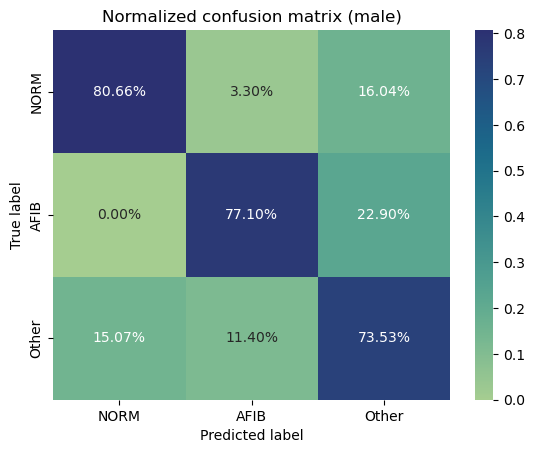

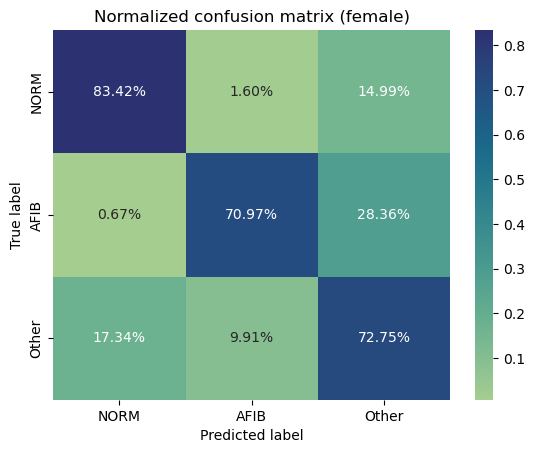

In [202]:
cm_ada2_male = confusion_matrix(y_true_ada2_male, y_pred_ada2_male)
cm_ada2_female = confusion_matrix(y_true_ada2_female, y_pred_ada2_female)

# normalized confusion matrix, male
cm_normalized_ada2_male = cm_ada2_male.astype('float') / cm_ada2_male.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_ada2_male, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (male)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

# normalized confusion matrix, female
cm_normalized_ada2_female = cm_ada2_female.astype('float') / cm_ada2_female.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_ada2_female, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (female)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

##### ROC-curve + ROC-AUC

In [203]:
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(ada)
clf.fit(X_train2_male, y_train2_male)

#Predict class probabilities of the input
pred_prob_ada2_female = clf.predict_proba(X_test2_female)
pred_prob_ada2_male = clf.predict_proba(X_test2_male)

In [204]:
from sklearn.metrics import auc

# roc curve for classes
fpr_ada2_male = {}
tpr_ada2_male = {}
thresh_ada2_male = {}
AUC_ada2_male = {}

fpr_ada2_female = {}
tpr_ada2_female = {}
thresh_ada2_female = {}
AUC_ada2_female = {}

n_class = 3

#female
for i in range(n_class):    
    fpr_ada2_female[i], tpr_ada2_female[i], thresh_ada2_female[i] = metrics.roc_curve(
                                                                y_test2_female, pred_prob_ada2_female[:,i], pos_label=i)
    AUC_ada2_female[i] = auc(fpr_ada2_female[i], tpr_ada2_female[i])

#male
for i in range(n_class):    
    fpr_ada2_male[i], tpr_ada2_male[i], thresh_ada2_male[i] = metrics.roc_curve(y_test2_male, pred_prob_ada2_male[:,i], pos_label=i)
    AUC_ada2_male[i] = auc(fpr_ada2_male[i], tpr_ada2_male[i])

## male
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)
for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_ada2_male[i], tpr_ada2_male[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_ada2_male["macro"] = fpr_grid
tpr_ada2_male["macro"] = mean_tpr
AUC_ada2_male["macro"] = auc(fpr_ada2_male["macro"], tpr_ada2_male["macro"])

## female
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_ada2_female[i], tpr_ada2_female[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_ada2_female["macro"] = fpr_grid
tpr_ada2_female["macro"] = mean_tpr
AUC_ada2_female["macro"] = auc(fpr_ada2_female["macro"], tpr_ada2_female["macro"])

AUC (male): {0: 0.9198113207547169, 1: 0.8948962210586083, 2: 0.7815769164808781, 'macro': 0.8654249945619441}
AUC (female): {0: 0.9227392505453731, 1: 0.84213692112852, 2: 0.7877610750896512, 'macro': 0.8508666377353209}


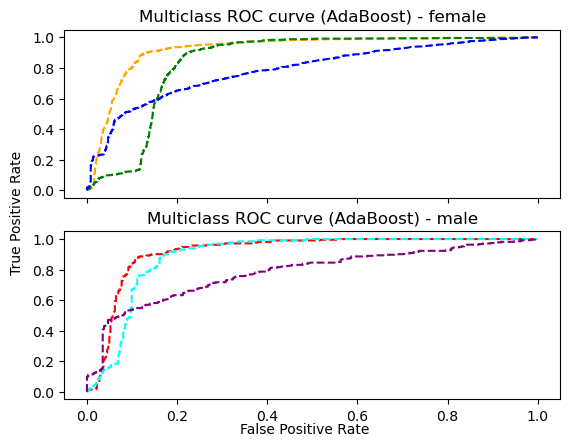

In [205]:
#subplots
fig, (ax1, ax2) = plt.subplots(2,sharex=True)

# plotting, male  
ax2.plot(fpr_ada2_male[0], tpr_ada2_male[0], linestyle='--', color='red', label = f'NORM vs Rest (AUC={AUC_ada2_male[0]:.3f})')
ax2.plot(fpr_ada2_male[1], tpr_ada2_male[1], linestyle='--', color='cyan', label = f'AFIB vs Rest (AUC={AUC_ada2_male[1]:.3f})')
ax2.plot(fpr_ada2_male[2], tpr_ada2_male[2], linestyle='--', color='purple', label = f'Other vs Rest(AUC={AUC_ada2_male[2]:.3f})')

# plotting, female
ax1.plot(fpr_ada2_female[0], tpr_ada2_female[0], linestyle='--', color='orange', label = f'NORM vs Rest (AUC={AUC_ada2_female[0]:.3f})')
ax1.plot(fpr_ada2_female[1], tpr_ada2_female[1], linestyle='--', color='green', label = f'AFIB vs Rest (AUC={AUC_ada2_female[1]:.3f})')
ax1.plot(fpr_ada2_female[2], tpr_ada2_female[2], linestyle='--', color='blue', label = f'Other vs Rest(AUC={AUC_ada2_female[2]:.3f})')
ax1.set_title('Multiclass ROC curve (AdaBoost) - female')

ax2.set_title('Multiclass ROC curve (AdaBoost) - male')
fig.text(0.04, 0.5, 'True Positive Rate', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'False Positive Rate', ha='center')

print(f'AUC (male): {AUC_ada2_male}')
print(f'AUC (female): {AUC_ada2_female}')

### EVC

#### Hard voting

In [206]:
# Implementing classifier
EVCh = VotingClassifier(estimators = [('KNN', KNN), ('DT', DT), ('RF',RF), ('Ada', ada)], voting ='hard')
EVCh.fit(X_train2_male, y_train2_male)

# testing model 20% male
y_pred_EVCh2_male = EVCh.predict(X_test2_male)
y_true_EVCh2_male = y_test2_male

score2_male = EVCh.score(X_test2_male, y_test2_male)
print(f"Score for male: {score2_male}")

# testing model 100% female
y_pred_EVCh2_female = EVCh.predict(X_test2_female)
y_true_EVCh2_female = y_test2_female

score2_female = EVCh.score(X_test2_female, y_test2_female)
print(f"Score for female: {score2_female}")

Score for male: 0.7983739837398374
Score for female: 0.7885475693408888


##### Classification report

In [207]:
#Classification report
target_names = ['NORM', 'AFIB', 'Other']

#male
class_report_EVCh2_male = classification_report(y_true_EVCh2_male, y_pred_EVCh2_male, target_names=target_names)
print(class_report_EVCh2_male)

#female
class_report_EVCh2_female = classification_report(y_true_EVCh2_female, y_pred_EVCh2_female, target_names=target_names)
print(class_report_EVCh2_female)

              precision    recall  f1-score   support

        NORM       0.83      0.87      0.85       212
        AFIB       0.73      0.80      0.76       131
       Other       0.81      0.74      0.78       272

    accuracy                           0.80       615
   macro avg       0.79      0.80      0.80       615
weighted avg       0.80      0.80      0.80       615

              precision    recall  f1-score   support

        NORM       0.78      0.87      0.82      1001
        AFIB       0.80      0.80      0.80       899
       Other       0.79      0.73      0.76      1453

    accuracy                           0.79      3353
   macro avg       0.79      0.80      0.79      3353
weighted avg       0.79      0.79      0.79      3353



##### Confusion matrix

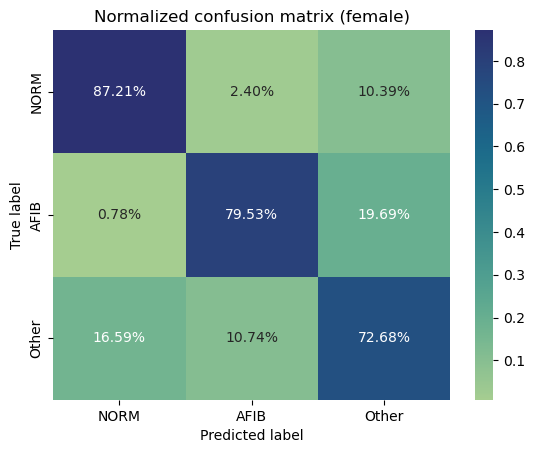

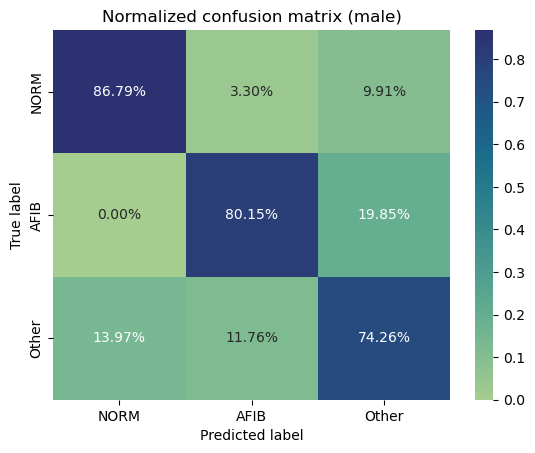

In [209]:
cm_EVCh2_male = confusion_matrix(y_true_EVCh2_male, y_pred_EVCh2_male)
cm_EVCh2_female = confusion_matrix(y_true_EVCh2_female, y_pred_EVCh2_female)

# normalized confusion matrix, female
cm_normalized_EVCh2_female = cm_EVCh2_female.astype('float') / cm_EVCh2_female.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_EVCh2_female, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (female)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

# normalized confusion matrix, male
cm_normalized_EVCh2_male = cm_EVCh2_male.astype('float') / cm_EVCh2_male.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_EVCh2_male, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (male)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

##### ROC-curve + ROC-AUC

In [213]:
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(EVCs)
clf.fit(X_train2_male, y_train2_male)

#Predict class probabilities of the input
pred_prob_EVCh2_female = clf.predict_proba(X_test2_female)
pred_prob_EVCh2_male = clf.predict_proba(X_test2_male)

In [211]:
from sklearn.metrics import auc
# roc curve for classes
fpr_EVCh2_male = {}
tpr_EVCh2_male = {}
thresh_EVCh2_male = {}
AUC_EVCh2_male = {}

fpr_EVCh2_female = {}
tpr_EVCh2_female = {}
thresh_EVCh2_female = {}
AUC_EVCh2_female = {}

n_class = 3

#male
for i in range(n_class):    
    fpr_EVCh2_male[i], tpr_EVCh2_male[i], thresh_EVCh2_male[i] = metrics.roc_curve(y_test2_male, pred_prob_EVCh2_male[:,i], pos_label=i)
    AUC_EVCh2_male[i] = auc(fpr_EVCh2_male[i], tpr_EVCh2_male[i])

#female
for i in range(n_class):    
    fpr_EVCh2_female[i], tpr_EVCh2_female[i], thresh_EVCh2_female[i] = metrics.roc_curve(
                                                                y_test2_female, pred_prob_EVCh2_female[:,i], pos_label=i)
    AUC_EVCh2_female[i] = auc(fpr_EVCh2_female[i], tpr_EVCh2_female[i])

## male
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)
for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_EVCh2_male[i], tpr_EVCh2_male[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_EVCh2_male["macro"] = fpr_grid
tpr_EVCh2_male["macro"] = mean_tpr
AUC_EVCh2_male["macro"] = auc(fpr_EVCh2_male["macro"], tpr_EVCh2_male["macro"])

## female
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_EVCh2_female[i], tpr_EVCh2_female[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_EVCh2_female["macro"] = fpr_grid
tpr_EVCh2_female["macro"] = mean_tpr
AUC_EVCh2_female["macro"] = auc(fpr_EVCh2_female["macro"], tpr_EVCh2_female["macro"])

AUC (male): {0: 0.9476567255021302, 1: 0.9484890543183395, 2: 0.8825887497856285, 'macro': 0.9262522851882674}
AUC (female): {0: 0.9427549491325002, 1: 0.9465989558261331, 2: 0.8648554714384032, 'macro': 0.9180585415629272}


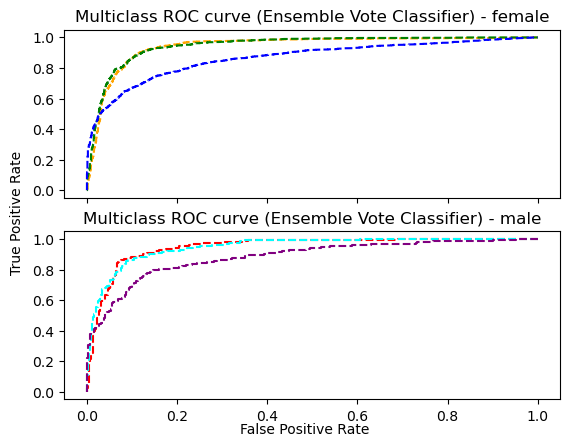

In [214]:
#subplots
fig, (ax1, ax2) = plt.subplots(2,sharex=True)

# plotting, male
ax2.plot(fpr_EVCh2_male[0], tpr_EVCh2_male[0], linestyle='--', color='red', label = f'NORM vs Rest (AUC={AUC_EVCh2_male[0]:.3f})')
ax2.plot(fpr_EVCh2_male[1], tpr_EVCh2_male[1], linestyle='--', color='cyan', label = f'AFIB vs Rest (AUC={AUC_EVCh2_male[1]:.3f})')
ax2.plot(fpr_EVCh2_male[2], tpr_EVCh2_male[2], linestyle='--', color='purple', label = f'Other vs Rest(AUC={AUC_EVCh2_male[2]:.3f})')
ax2.set_title('Multiclass ROC curve (Ensemble Vote Classifier) - male')

# plotting, female
ax1.plot(fpr_EVCh2_female[0], tpr_EVCh2_female[0], linestyle='--', color='orange', label = f'NORM vs Rest (AUC={AUC_EVCh2_female[0]:.3f})')
ax1.plot(fpr_EVCh2_female[1], tpr_EVCh2_female[1], linestyle='--', color='green', label = f'AFIB vs Rest (AUC={AUC_EVCh2_female[1]:.3f})')
ax1.plot(fpr_EVCh2_female[2], tpr_EVCh2_female[2], linestyle='--', color='blue', label = f'Other vs Rest(AUC={AUC_EVCh2_female[2]:.3f})')
ax1.set_title('Multiclass ROC curve (Ensemble Vote Classifier) - female')

fig.text(0.04, 0.5, 'True Positive Rate', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'False Positive Rate', ha='center')

print(f'AUC (male): {AUC_EVCh2_male}')
print(f'AUC (female): {AUC_EVCh2_female}')

#### Soft voting

In [215]:
# Implementing classifier
EVCs = VotingClassifier(estimators = [('KNN', KNN), ('DT', DT), ('RF',RF), ('Ada', ada)], voting ='soft')
EVCs.fit(X_train2_male, y_train2_male)

# testing model 20% male
y_pred_EVCs2_male = EVCs.predict(X_test2_male)
y_true_EVCs2_male = y_test2_male

score2_male = EVCs.score(X_test2_male, y_test2_male)
print(f"Score for male: {score2_male}")

# testing model 100% female
y_pred_EVCs2_female = EVCs.predict(X_test2_female)
y_true_EVCs2_female = y_test2_female

score2_female = EVCs.score(X_test2_female, y_test2_female)
print(f"Score for female: {score2_female}")

Score for male: 0.7967479674796748
Score for female: 0.7894422904861318


##### Classification report

In [216]:
#Classification report
target_names = ['NORM', 'AFIB', 'Other']
#male
class_report_EVCs2_male = classification_report(y_true_EVCs2_male, y_pred_EVCs2_male, target_names=target_names)
print(class_report_EVCs2_male)

#female
class_report_EVCs2_female = classification_report(y_true_EVCs2_female, y_pred_EVCs2_female, target_names=target_names)
print(class_report_EVCs2_female)

              precision    recall  f1-score   support

        NORM       0.85      0.86      0.86       212
        AFIB       0.73      0.76      0.74       131
       Other       0.79      0.76      0.78       272

    accuracy                           0.80       615
   macro avg       0.79      0.79      0.79       615
weighted avg       0.80      0.80      0.80       615

              precision    recall  f1-score   support

        NORM       0.79      0.85      0.82      1001
        AFIB       0.81      0.78      0.79       899
       Other       0.78      0.75      0.76      1453

    accuracy                           0.79      3353
   macro avg       0.79      0.79      0.79      3353
weighted avg       0.79      0.79      0.79      3353



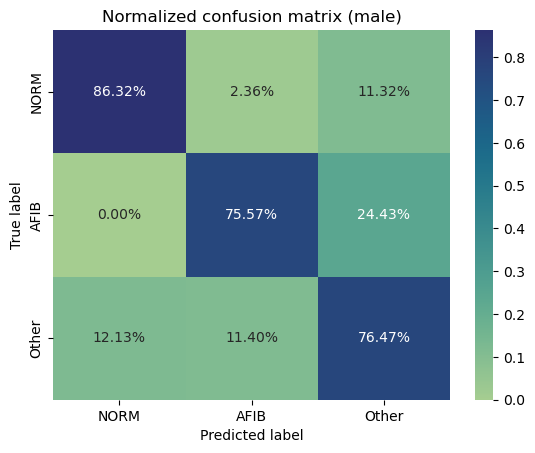

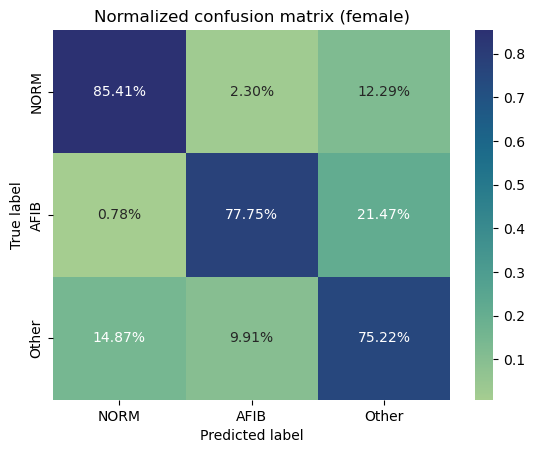

In [218]:
cm_EVCs2_male = confusion_matrix(y_true_EVCs2_male, y_pred_EVCs2_male)
cm_EVCs2_female = confusion_matrix(y_true_EVCs2_female, y_pred_EVCs2_female)

# normalized confusion matrix, male
cm_normalized_EVCs2_male = cm_EVCs2_male.astype('float') / cm_EVCs2_male.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_EVCs2_male, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (male)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

# normalized confusion matrix, female
cm_normalized_EVCs2_female = cm_EVCs2_female.astype('float') / cm_EVCs2_female.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm_normalized_EVCs2_female, annot=True,fmt='.2%', xticklabels = target_names, yticklabels = target_names, linewidths = 0.001, cmap="crest", linecolor = 'grey')
ax.set_title('Normalized confusion matrix (female)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

##### ROC-curve + ROC-AUC

In [220]:
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(EVCs)
clf.fit(X_train2_male, y_train2_male)

#Predict class probabilities of the input
pred_prob_EVCs2_female = clf.predict_proba(X_test2_female)
pred_prob_EVCs2_male = clf.predict_proba(X_test2_male)

In [221]:
from sklearn.metrics import auc
# roc curve for classes
fpr_EVCs2_male = {}
tpr_EVCs2_male = {}
thresh_EVCs2_male = {}
AUC_EVCs2_male = {}

fpr_EVCs2_female = {}
tpr_EVCs2_female = {}
thresh_EVCs2_female = {}
AUC_EVCs2_female = {}

n_class = 3

#female
for i in range(n_class):    
    fpr_EVCs2_female[i], tpr_EVCs2_female[i], thresh_EVCs2_female[i] = metrics.roc_curve(
                                                                y_test2_female, pred_prob_EVCs2_female[:,i], pos_label=i)
    AUC_EVCs2_female[i] = auc(fpr_EVCs2_female[i], tpr_EVCs2_female[i])

#male
for i in range(n_class):    
    fpr_EVCs2_male[i], tpr_EVCs2_male[i], thresh_EVCs2_male[i] = metrics.roc_curve(y_test2_male, pred_prob_EVCs2_male[:,i], pos_label=i)
    AUC_EVCs2_male[i] = auc(fpr_EVCs2_male[i], tpr_EVCs2_male[i])

## male
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)
for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_EVCs2_male[i], tpr_EVCs2_male[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_EVCs2_male["macro"] = fpr_grid
tpr_EVCs2_male["macro"] = mean_tpr
AUC_EVCs2_male["macro"] = auc(fpr_EVCs2_male["macro"], tpr_EVCs2_male["macro"])

## female
# macro average
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_class):
    mean_tpr += np.interp(fpr_grid, fpr_EVCs2_female[i], tpr_EVCs2_female[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_class

fpr_EVCs2_female["macro"] = fpr_grid
tpr_EVCs2_female["macro"] = mean_tpr
AUC_EVCs2_female["macro"] = auc(fpr_EVCs2_female["macro"], tpr_EVCs2_female["macro"])

AUC (male): {0: 0.9472002434570905, 1: 0.9494747965428049, 2: 0.8833122534728176, 'macro': 0.9266935788587942}
AUC (female): {0: 0.9419128915302386, 1: 0.9469910422972913, 2: 0.8647687180787482, 'macro': 0.9178760799791366}


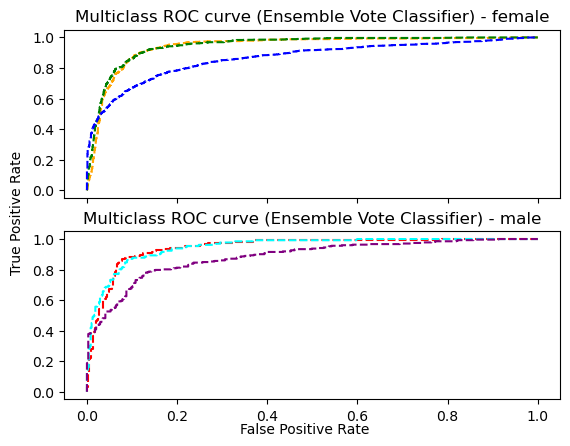

In [224]:
#subplots
fig, (ax1, ax2) = plt.subplots(2,sharex=True)

# plotting, male
ax2.plot(fpr_EVCs2_male[0], tpr_EVCs2_male[0], linestyle='--', color='red', label = f'NORM vs Rest (AUC={AUC_EVCs2_male[0]:.3f})')
ax2.plot(fpr_EVCs2_male[1], tpr_EVCs2_male[1], linestyle='--', color='cyan', label = f'AFIB vs Rest (AUC={AUC_EVCs2_male[1]:.3f})')
ax2.plot(fpr_EVCs2_male[2], tpr_EVCs2_male[2], linestyle='--', color='purple', label = f'Other vs Rest(AUC={AUC_EVCs2_male[2]:.3f})')
ax2.set_title('Multiclass ROC curve (Ensemble Vote Classifier) - male')

# plotting, female
ax1.plot(fpr_EVCs2_female[0], tpr_EVCs2_female[0], linestyle='--', color='orange', label = f'NORM vs Rest (AUC={AUC_EVCs2_female[0]:.3f})')
ax1.plot(fpr_EVCs2_female[1], tpr_EVCs2_female[1], linestyle='--', color='green', label = f'AFIB vs Rest (AUC={AUC_EVCs2_female[1]:.3f})')
ax1.plot(fpr_EVCs2_female[2], tpr_EVCs2_female[2], linestyle='--', color='blue', label = f'Other vs Rest(AUC={AUC_EVCs2_female[2]:.3f})')
ax1.set_title('Multiclass ROC curve (Ensemble Vote Classifier) - female')

fig.text(0.04, 0.5, 'True Positive Rate', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'False Positive Rate', ha='center')

print(f'AUC (male): {AUC_EVCs2_male}')
print(f'AUC (female): {AUC_EVCs2_female}')